In [1]:
import os
import csv
import optuna
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Input, LSTM, Dense, Activation, Dropout
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from math import sqrt
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from numpy import array
import keras.backend as K
import itertools
#!pip install pydot
    
# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')
    
def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))
    
def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
    
# convert time series into a supervised learning problem
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
# Convert time series into a supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):

    n_vars = 1 if type(data) is list else data.shape[1]
    cols, names = list(), list()
    df = DataFrame(data)
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
    	cols.append(df.shift(i))
    	names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df[0].shift(-i)) # df[0] for temperature
        if i == 0:
            names += [('var%d(t)' % (1))] # % (1) for temperature
        else:            
            names += [('var%d(t+%d)' % (1, i))] # % (1) for temperature
    
    # put it all together
    agg = concat(cols, axis=1)

    if dropnan:
        #Drop rows containing NaN
        agg.dropna(inplace=True)

    #print("Agg:")
    agg.columns = names
    #print(type(agg))
    #print(agg)

    #print("Test columns:")
    #print(agg.iloc[:, -37]) # Column containing response actual values (temperature) at time t-3
    #print(agg.iloc[:, -25]) # Column containing response actual values (temperature) at time t-2
    #print(agg.iloc[:, -13]) # Column containing response actual values (temperature) at time t-1
    #print(agg.iloc[:, -1]) # Column containing response actual values (temperature) at time t
    
    return agg
     
# create a differenced series
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)
     
# transform series into training sets for supervised learning
def prepare_training_data(data, n_lag, n_seq, n_time_steps):
    
    #Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    print(n_vars)
    print(len(data))
    print(type(data))

    # Each weather station has 27 time steps (the first 23 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 26-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 23 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(len(data)):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    #print("Diff values:")
    #print(len(diff_values))
    #print(len(diff_values[0]))
    #print(len(diff_values_for_training))
    #print(len(diff_values_for_training[0]))
    
    # rescale values to 0, 1
    scaler_all_features =  MinMaxScaler(feature_range=(0, 1))
    scaler =  MinMaxScaler(feature_range=(0, 1))
    #diff_values_training = np.array(diff_values_for_training)
    #diff_values_training = diff_values_training.reshape(1, -1) 
    train_scaled_values = scaler_all_features.fit_transform(diff_values)
    response_train_values = []
    for i in range(len(diff_values)):
        response_train_values.append(diff_values[i][0]) # Uses first column (temperatures) as response variable
    response_train_values = np.array(response_train_values)
    response_train_values = response_train_values.reshape(len(response_train_values), 1)

    # Fit the scaler for just the response variable for use later when forecasting
    response_scaled_values = scaler.fit_transform(response_train_values) 
    scaled_values = scaler_all_features.transform(diff_values)

    #print("Scaled values rows:")
    #print(len(scaled_values))

    train = []

    # Transform each weather station as a separate "batch"
    for ws in range(len(data)):
        # transform into a supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        #print("Batch "+str(ws+1)+":")
        #print("Range: "+str(first)+"-"+str(last))
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        train.append([supervised_values])
        #print("Supervised count:")
        #print(len(supervised_values))
        #print(len(supervised_values[0]))
    
    return scaler, scaler_all_features, train

# transform series into testing and validation sets for supervised learning
def prepare_testing_and_validation_data(data, n_lag, n_seq, n_time_steps, scaler_all_features):
    
    # Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    print(n_vars)
    print(len(data))
    print(type(data))

    # Each weather station has 227 time steps (the first 180 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 226-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 180 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(len(data)):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    #print("Diff values:")
    #print(len(diff_values))
    #print(len(diff_values[0]))
    #print(len(diff_values_for_training))
    #print(len(diff_values_for_training[0]))
    
    # rescale values to 0, 1
    scaled_values = scaler_all_features.transform(diff_values)

    validation = []
    test = []

    
    
    # Transform each weather station as a separate "batch"
    for ws in range(len(data)):
        # transform into a supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        #print("Batch "+str(ws+1)+":")
        #print("Range: "+str(first)+"-"+str(last))
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        # training/test/validation split is 80%/10%/10%
        if ws < 2:
            test.append([supervised_values])
        else:
            validation.append([supervised_values])
        #print("Supervised count:")
        #print(len(supervised_values))
        #print(len(supervised_values[0]))
    
    return validation, test
    
def plot_kfold(cv, X, y, ax, n_splits, xlim_max=105):
    
    #Plots the indices for a cross-validation object.
    #Taken from https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
    #Parameters:
    #cv: Cross-validation object
    #X: Feature set
    #y: Target variable
    #ax: Matplotlib axis object
    #n_splits: Number of folds in the cross-validation
    #xlim_max: Maximum limit for the x-axis
        
    # Set color map for the plot
    cmap_cv = plt.cm.coolwarm
    cv_split = cv.split(X=X, y=y)
        
    for i_split, (train_idx, test_idx) in enumerate(cv_split):
        # Create an array of NaNs and fill in training/testing indices
        indices = np.full(len(X), np.nan)
        indices[test_idx], indices[train_idx] = 1, 0
            
        # Plot the training and testing indices
        ax_x = range(len(indices))
        ax_y = [i_split + 0.5] * len(indices)
        ax.scatter(ax_x, ax_y, c=indices, marker="_", 
                   lw=10, cmap=cmap_cv, vmin=-0.2, vmax=1.2)
    
        # Set y-ticks and labels
        y_ticks = np.arange(n_splits) + 0.5
        ax.set(yticks=y_ticks, yticklabels=range(n_splits),
               xlabel="Weather Station index (file_id)", ylabel="Fold",
               ylim=[n_splits, -0.2], xlim=[0, xlim_max])
    
        # Set plot title and create legend
        ax.set_title("KFold", fontsize=14)
        legend_patches = [Patch(color=cmap_cv(0.8), label="Testing set"), 
                          Patch(color=cmap_cv(0.02), label="Training set")]
        ax.legend(handles=legend_patches, loc=(1.03, 0.8))
    
#Main

#Configure
n_seq = 5
if n_seq > 3:
    n_lag = 25 - n_seq
else:
    n_lag = 22
n_time_steps = 27
n_test = 1

print("Model Parameters:")
print("n_lag (number of input time steps): "+str(n_lag))
print("n_seq (number of output/future prediction time steps): "+str(n_seq))

# Create 2D array with file_ids to use for sample creation
array = np.array([
    6501, 6541, 6640, 6668, 6678, 
    6687, 6697, 6714, 6744, 6772, 
    6783, 6840, 6844, 6854, 6870, 
    6891, 6895, 6899, 6901, 6909, 
    6929, 6950, 6963, 6969, 6994, 
    7032, 7057, 7094, 7095, 7100, 
    7108, 7116, 7119, 7131, 7139, 
    7152, 7155, 7156, 7182, 7193, 
    7202, 7239, 7280, 7286, 7287, 
    7311, 7321, 7329, 7347, 7350, 
    7354, 7357, 7361, 7414, 7423, 
    7424, 7432, 7463, 7482, 7489, 
    7528, 7531, 7534, 7538, 7549, 
    7553, 7555, 7562, 7571, 7573, 
    7574, 7575, 7585, 7599, 7603, 
    7606, 7622, 7652, 7671, 7704, 
    7786, 7805, 7816, 7838, 7861, 
    7862, 7863, 7870, 7892, 7907, 
    7938, 7962, 7979, 7987, 7999, 
    8000, 8034, 8083, 8120, 8133, 
    8184, 8186, 8247, 8248, 9858])
    
#Create arrays holding the 5-fold cross-validation indices gathered for consistency across models
train_array = []
test_array = []
    
train_array.append([5, 9, 21, 22, 41, 42, 45, 46, 52, 66, 68, 72, 79, 81, 82, 83, 90, 92, 95])
test_array.append([4, 10, 47, 53, 94])
    
train_array.append([4, 9, 10, 21, 41, 45, 46, 47, 52, 53, 66, 68, 81, 82, 83, 90, 92, 94, 95])
test_array.append([5, 22, 42, 72, 79])
    
train_array.append([4, 5, 10, 21, 22, 41, 42, 46, 47, 52, 53, 72, 79, 82, 83, 90, 92, 94, 95])
test_array.append([9, 45, 66, 68, 81])
    
train_array.append([4, 5, 9, 10, 21, 22, 42, 45, 47, 52, 53, 66, 68, 72, 79, 81, 82, 92, 94, 95])
test_array.append([41, 46, 83, 90])
    
train_array.append([4, 5, 9, 10, 22, 41, 42, 45, 46, 47, 53, 66, 68, 72, 79, 81, 83, 90, 94])
test_array.append([21, 52, 82, 92, 95])
    
# Equations for three Principal Components from PCA using response variables combined with other predictors
#PC1=-0.0002714X1+0.02612X2+0.03858X3-0.007658X4+0.001592X5-0.02087X6+0.8564X7-0.1468X8+0.01192X9-0.0001049X10+0.01913X11+0.02076X12
#PC2=0.0003944X1+0.002204X2+0.01052X3+0.3248X4-0.0009976X5-0.04421X6+2.3406X7+0.06103X8+0.08841X9+0.00009018X10+0.05678X11-0.002022X12
#PC3=-0.00007998X1-0.0006124X2-0.001063X3-0.01855X4+0.00001956X5+0.01170X6+0.6076X7+0.4664X8-0.002995X9+0.008185X10+0.8815X11-0.0004730X12
    
# Equations for three Principal Components from PCA omitting both response variables,
#PC-1=-0.0004514X1+0.03194X2-0.04343X3+0.002243X4-0.02252X5+0.9877X6-0.2265X7+0.006144X8-0.0001488X9+0.02943X10
#PC-2=0.0001702X1+0.005484X2+0.2057X3-0.0003188X4-0.02584X5+1.6963X6-0.05890X7+0.05809X8+1.9748X9+0.03686X10
#PC-3=-0.00006323X1-0.001180X2-0.02384X3-0.00002833X4+0.01170X5+0.5204X6+0.4791X7-0.004318X8+0.008271X9+0.8765X10
    
# Get the current working directory 
current_directory = os.getcwd() 
    
# Print the current working directory 
print(current_directory)
    
# Define the directory containing the files 
path = current_directory+"\\Modeling\\"
print(path)
    
filename = path + 'Final_Yearly_Dataset.csv'
    
# load dataset
df = read_csv(filename, header=0, parse_dates=[0], index_col=0, date_format='%Y-%m')
    
df = df.rename(columns={'Unnamed: 0' : 'indices'})
    
#Remove unused columns
df = df.drop(['vapor_pressure'], axis=1)
    
# Round numbers in columns to reasonable precision,
df['temperatures'] = np.round(df['temperatures'], 2)
df['slp'] = np.round(df['slp'], 2)
df['wet_bulb_temperature'] = np.round(df['wet_bulb_temperature'], 2)
df['specific_humidity'] = np.round(df['specific_humidity'], 2)
df['GHI'] = np.round(df['GHI'], 2)
df['PRCP'] = np.round(df['PRCP'], 2)
df['SNDP'] = np.round(df['SNDP'], 2)
df['solar_activity'] = np.round(df['solar_activity'], 2)
df['ONI'] = np.round(df['ONI'], 2)
df['water'] = np.round(df['water'], 0)
df['region'] = np.round(df['region'], 0)
    
df_trimmed = df[df['file_id'] != 7533] # Remove file_id 7533 so there are 105 weather stations for 5-fold CV
df_trimmed = df_trimmed.drop(['Year', 'date', 'latitude', 'longitude', 'elevation'], axis=1)

#Test model and accuracy when solar activity is removed as a predictor
df_trimmed = df_trimmed.drop(['solar_activity'], axis=1)

n_vars = df_trimmed.shape[1]-1

X = []
y = []
    
for i in array:
    add_to_X = [] # create list to store each column to add to X
    new_df = df_trimmed[df_trimmed['file_id'] == i].drop(['file_id'], axis=1)
    add_to_y = []
    for j in range(new_df.shape[0]):
        add_to_y.append(new_df['temperatures'].iloc[j])
    y.append(add_to_y)
    #new_df = new_df.drop(['temperatures'], axis=1)
    columns_list = new_df.columns.tolist()
    for j in range(new_df.shape[0]):
        l=0
        new_row = []
        for m in columns_list:
            new_row.append(new_df.iloc[j, l])
            l += 1
        add_to_X.append(new_row)
    X.append(add_to_X)

print(df_trimmed)
print(new_df)
print(X[0])

#Perform k-fold cross-validation
#Taken from: https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
#k = 5  # Number of folds
#kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
#for i, (train_index, test_index) in enumerate(kf.split(X)):
#    print(f"Fold {i}:")
#    print(f"  Training dataset index: {train_index}")
#    print(f"  Test dataset index: {test_index}")
    
#for train_indices, test_indices in kf.split(X):
#    print('Train: %s | test: %s' % (train_indices, test_indices))
    
# Create figure and axis
#fig, ax = plt.subplots(figsize=(6, 3))
#plot_kfold(kf, X, y, ax, k)
#plt.tight_layout()
#fig.subplots_adjust(right=0.6)
    
#Create train and test sets for each cross-validation split
train_X = []
train_y = []
val_X = []
val_y = []
for i in range(5):
    print(f"Fold {i+1}")
    #Add each corresponding sample for each entry of train index 
    train_X_rows = [] # Stores all the samples for one fold of train_X
    train_y_rows = [] # Stores all the samples for one fold of train_y
    for j in train_array[i]:
        train_X_rows.append(X[j])
        train_y_rows.append(y[j])
    # Stores one fold of the train dataset
    train_X.append(train_X_rows)
    train_y.append(train_y_rows)
    #Add each corresponding sample for each entry of the validation index 
    val_X_rows = [] # Stores all the samples for one fold of val_X
    val_y_rows = [] # Stores all the samples for one fold of val_y
    for j in test_array[i]: 
            val_X_rows.append(X[j])
            val_y_rows.append(y[j])
    # Stores one fold of the validation dataset
    val_X.append(val_X_rows)
    val_y.append(val_y_rows) 
    
    #print("Train_X Fold "+str(i)+":")
    #print(len(train_X[i]))
    #print(len(train_X[i][0]))
    #print(len(train_X[i][0][0])) 
    #print("Train_y Fold "+str(i)+":")
    #print(len(train_y[i]))
    #print(len(train_y[i][0]))
    #print(train_y[i][0][0])
    #print("Validation_X Fold "+str(i)+":")
    #print(len(val_X[i]))
    #print(len(val_X[i][0]))
    #print(len(val_X[i][0][0]))
    #print("Validation_y Fold "+str(i)+":")
    #print(len(val_y[i]))
    #print(len(val_y[i][0]))
    #print(val_y[i][0][0])
    
#Convert 3D arrays to DataFrames
df_X = []
df_y = []
val_df_X = []
val_df_y = []
dataset = []
dataset_test = []
scaler = []
scaler_all_features = []
train = []
test = []
validation = []

for i in range(5):
    dataset_scaling = [] # Holds all 84 weather station rows to train the scaling function
    dataset_testing = [] # Holds remaining 21 weather station rows for testing and validation
    print("Fold "+str(i+1)+":")
    #Transform train_X to the correct format
    df1 = []
    dataset_df = [] # captures each weather station's dataset as values for training scaler mapping
    df_X.append(pd.DataFrame(train_X[i]))
    X_t = df_X[i].transpose()
    if i==3:
        train_size = 20
        val_size = 4
    else:
        train_size = 19
        val_size = 5
        
    for k in range(train_size):
        X = np.array(X_t.iloc[:, k])
        df = pd.DataFrame()
        for j in range(n_time_steps):
            new_row = pd.DataFrame(X[j]).transpose()
            new_row.columns = new_df.columns
            # Add the new row
            df = pd.concat([df, new_row], ignore_index=True)
        df.columns = new_df.columns
        df1.append(df)
        dataset_df.append(df.values)
        dataset_scaling.append(df.values)
    df_X[i] = df1
    dataset.append(dataset_df)
     

    #print(len(dataset))
    #print(len(dataset[0]))
    #print(len(dataset_scaling))
    #print(len(dataset_scaling[:][0]))
    #print("Stop")
    
    #Transform train_y to the correct format
    df2 = []
    df_y.append(pd.DataFrame(train_y[i]))
    y_t = df_y[i].transpose()
    
    for j in range(train_size):
        y = np.array(y_t.iloc[:, j])
        y = pd.DataFrame(y)
        y.columns = ['temperatures']
        df2.append(y)
    df_y[i] = df2

    #Transform val_X to the correct format
    df3 = []
    dataset_vl_df = [] # captures each weather station's dataset as values for training scaler mapping
    val_df_X.append(pd.DataFrame(val_X[i]))
    val_X_t = val_df_X[i].transpose()
    for k in range(val_size):
        vl_X = np.array(val_X_t.iloc[:, k])
        vl_df = pd.DataFrame()
        for j in range(n_time_steps):
            new1_row = pd.DataFrame(vl_X[j]).transpose()
            new1_row.columns = new_df.columns
            # Add the new row
            vl_df = pd.concat([vl_df, new1_row], ignore_index=True)
        vl_df.columns = new_df.columns
        df3.append(vl_df)
        dataset_vl_df.append(vl_df.values)
        dataset_testing.append(vl_df.values)
    val_df_X[i] = df3
    dataset_test.append(dataset_vl_df)

    #Transform val_y to the correct format
    df4 = []
    val_df_y.append(pd.DataFrame(train_y[i]))
    val_y_t = val_df_y[i].transpose()
    
    for j in range(val_size):
        v_y = np.array(val_y_t.iloc[:, j])
        v_y = pd.DataFrame(v_y)
        v_y.columns = ['temperatures']
        df4.append(v_y)
    val_df_y[i] = df4
    
    scaler.append(MinMaxScaler(feature_range=(0, 1)))
    scaler_all_features.append(MinMaxScaler(feature_range=(0, 1)))
    train.append([1])
    test.append([1])
    validation.append([1])
    
    # prepare data
    scaler[i], scaler_all_features[i], train[i] = prepare_training_data(dataset_scaling, n_lag, n_seq, n_time_steps)

    validation[i], test[i] = prepare_testing_and_validation_data(dataset_testing, n_lag, n_seq, n_time_steps, scaler_all_features[i])

    #Reshape dimensionality
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]
    print(np.array(train1).shape)
    print(np.array(test1).shape)
    print(np.array(validation1).shape)
    train2 = []
    test2 = []
    validation2 = []

    for k in range(train_size):
        train2.append(train1[k][0])
        
    for k in range(2):
        test2.append(test1[k][0])

    for k in range(val_size-2):
        validation2.append(validation1[k][0])

    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2

    #Reshape dimensionality (again)
    dim_size = n_seq + n_vars*n_lag
    train1 = np.array(train[i]).reshape(train_size, dim_size)
    test1 = np.array(test[i]).reshape(2, dim_size)
    validation1 = np.array(validation[i]).reshape(val_size-2, dim_size)
    train2 = pd.DataFrame(train1).values
    test2 = pd.DataFrame(test1).values
    validation2 = pd.DataFrame(validation1).values
    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    print(train2)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2
    
    #X_train = train1[:][:-n_seq]
    #y_train = train1[:][-n_seq:]
    #X_test = test1[:][:-n_seq]
    #y_test = test1[:][-n_seq:]

print("Finished")

Model Parameters:
n_lag (number of input time steps): 20
n_seq (number of output/future prediction time steps): 5
C:\Users\User
C:\Users\User\Modeling\
     file_id  temperatures      slp  wet_bulb_temperature  specific_humidity  \
0       6678         20.84  1016.20                 18.08              12.82   
1       6678         20.69  1017.48                 17.71              12.33   
2       6678         20.47  1018.26                 17.29              12.14   
3       6678         20.30  1018.41                 17.20              11.90   
4       6678         20.46  1017.92                 17.75              12.75   
..       ...           ...      ...                   ...                ...   
643     8000         13.02  1016.94                  7.64               5.15   
644     8000         13.47  1016.16                  7.88               5.24   
645     8000         11.84  1017.90                  7.13               5.36   
646     8000         12.86  1016.17             

In [2]:
print(n_seq)
print(n_lag)
print(np.array(train[1]).shape)
print(np.array(test[1]).shape)

5
20
(19, 225)
(2, 225)


[I 2025-06-05 03:49:41,104] A new study created in memory with name: no-name-db4a4239-fa13-4011-be3e-2ede9576c43c
[I 2025-06-05 03:53:28,523] Trial 0 finished with value: 0.13486671149730683 and parameters: {'lr': 0.0033081834667969164, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.4028196778695132}. Best is trial 0 with value: 0.13486671149730683.


Cross Validation Accuracies:
[0.12706917524337769, 0.13941290974617004, 0.10201199352741241, 0.1699581742286682, 0.13588130474090576]
Mean Cross Validation Accuracy:
0.13486671149730683
Standard Deviation of Cross Validation Accuracy:
0.02187849235713965


[I 2025-06-05 03:55:37,895] Trial 1 finished with value: 0.11520906537771225 and parameters: {'lr': 0.7512559812474183, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.4441151092268121}. Best is trial 1 with value: 0.11520906537771225.


Cross Validation Accuracies:
[0.15967901051044464, 0.11879698932170868, 0.09710683673620224, 0.10892771184444427, 0.09153477847576141]
Mean Cross Validation Accuracy:
0.11520906537771225
Standard Deviation of Cross Validation Accuracy:
0.024158092485340874


[I 2025-06-05 03:58:32,913] Trial 2 finished with value: 3.5564801692962646 and parameters: {'lr': 0.48125076532356376, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.3331088154934741}. Best is trial 1 with value: 0.11520906537771225.


Cross Validation Accuracies:
[5.470562934875488, 2.9991538524627686, 2.9462368488311768, 3.585219144821167, 2.7812280654907227]
Mean Cross Validation Accuracy:
3.5564801692962646
Standard Deviation of Cross Validation Accuracy:
0.9948431152964768


[I 2025-06-05 04:00:32,969] Trial 3 finished with value: 8.842659759521485 and parameters: {'lr': 0.7993198518213732, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.25669717917930207}. Best is trial 1 with value: 0.11520906537771225.


Cross Validation Accuracies:
[7.6900177001953125, 3.543303966522217, 5.420893669128418, 6.170714855194092, 21.388368606567383]
Mean Cross Validation Accuracy:
8.842659759521485
Standard Deviation of Cross Validation Accuracy:
6.413335150476596


[I 2025-06-05 04:03:21,970] Trial 4 finished with value: 1.1235922932624818 and parameters: {'lr': 0.017047069895659964, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.345889894136581}. Best is trial 1 with value: 0.11520906537771225.


Cross Validation Accuracies:
[1.0446525812149048, 1.260866641998291, 1.0757499933242798, 1.3856186866760254, 0.8510735630989075]
Mean Cross Validation Accuracy:
1.1235922932624818
Standard Deviation of Cross Validation Accuracy:
0.18454750052907679


[I 2025-06-05 04:06:14,809] Trial 5 finished with value: 0.1847828060388565 and parameters: {'lr': 0.07044298562290018, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.3438451013861479}. Best is trial 1 with value: 0.11520906537771225.


Cross Validation Accuracies:
[0.15866132080554962, 0.24573267996311188, 0.13714289665222168, 0.12816236913204193, 0.2542147636413574]
Mean Cross Validation Accuracy:
0.1847828060388565
Standard Deviation of Cross Validation Accuracy:
0.054209686773818065


[I 2025-06-05 04:09:26,166] Trial 6 finished with value: 0.09915148317813874 and parameters: {'lr': 0.09741857112394196, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.3003083902366188}. Best is trial 6 with value: 0.09915148317813874.


Cross Validation Accuracies:
[0.1439155489206314, 0.08731439709663391, 0.10107245296239853, 0.081101194024086, 0.08235382288694382]
Mean Cross Validation Accuracy:
0.09915148317813874
Standard Deviation of Cross Validation Accuracy:
0.023475956395488985


[I 2025-06-05 04:12:03,148] Trial 7 finished with value: 0.27766757011413573 and parameters: {'lr': 0.005673796796438781, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.3385602044154885}. Best is trial 6 with value: 0.09915148317813874.


Cross Validation Accuracies:
[0.28388088941574097, 0.24374011158943176, 0.28739133477211, 0.2499462366104126, 0.3233792781829834]
Mean Cross Validation Accuracy:
0.27766757011413573
Standard Deviation of Cross Validation Accuracy:
0.0287828489333807


[I 2025-06-05 04:14:57,902] Trial 8 finished with value: 0.09624346494674682 and parameters: {'lr': 0.031245587917521907, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.2185245314065888}. Best is trial 8 with value: 0.09624346494674682.


Cross Validation Accuracies:
[0.14438793063163757, 0.08815228193998337, 0.08978074789047241, 0.08575751632452011, 0.07313884794712067]
Mean Cross Validation Accuracy:
0.09624346494674682
Standard Deviation of Cross Validation Accuracy:
0.024774591724141138


[I 2025-06-05 04:18:43,842] Trial 9 finished with value: 0.09346044957637786 and parameters: {'lr': 0.019059087304920227, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.3128556917904717}. Best is trial 9 with value: 0.09346044957637786.


Cross Validation Accuracies:
[0.13541392982006073, 0.08342631906270981, 0.10262443125247955, 0.0714748203754425, 0.07436274737119675]
Mean Cross Validation Accuracy:
0.09346044957637786
Standard Deviation of Cross Validation Accuracy:
0.023634072694993312


[I 2025-06-05 04:20:52,906] Trial 10 finished with value: 0.14197050780057907 and parameters: {'lr': 0.001099352880272705, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.11098564352740753}. Best is trial 9 with value: 0.09346044957637786.


Cross Validation Accuracies:
[0.21146272122859955, 0.16058862209320068, 0.11278365552425385, 0.12225188314914703, 0.10276565700769424]
Mean Cross Validation Accuracy:
0.14197050780057907
Standard Deviation of Cross Validation Accuracy:
0.039883627559626836


[I 2025-06-05 04:23:56,909] Trial 11 finished with value: 0.09922558963298797 and parameters: {'lr': 0.023325023976964517, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.1927200790855394}. Best is trial 9 with value: 0.09346044957637786.


Cross Validation Accuracies:
[0.12437324225902557, 0.09722680598497391, 0.10969651490449905, 0.08873777836561203, 0.07609360665082932]
Mean Cross Validation Accuracy:
0.09922558963298797
Standard Deviation of Cross Validation Accuracy:
0.016680063948198574


[I 2025-06-05 04:26:21,537] Trial 12 finished with value: 0.0990823470056057 and parameters: {'lr': 0.09741334326507345, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.2203015048650474}. Best is trial 9 with value: 0.09346044957637786.


Cross Validation Accuracies:
[0.1441318243741989, 0.05912790820002556, 0.11866715550422668, 0.08408070355653763, 0.0894041433930397]
Mean Cross Validation Accuracy:
0.0990823470056057
Standard Deviation of Cross Validation Accuracy:
0.029421401213127665


[I 2025-06-05 04:29:26,567] Trial 13 finished with value: 0.15087592601776123 and parameters: {'lr': 0.009075145528272696, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.15509878107689135}. Best is trial 9 with value: 0.09346044957637786.


Cross Validation Accuracies:
[0.21720419824123383, 0.1486518383026123, 0.1599140167236328, 0.08096960186958313, 0.14763997495174408]
Mean Cross Validation Accuracy:
0.15087592601776123
Standard Deviation of Cross Validation Accuracy:
0.04332075456668577


[I 2025-06-05 04:31:27,264] Trial 14 finished with value: 0.11642893105745315 and parameters: {'lr': 0.04353340039891705, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.25812856624423197}. Best is trial 9 with value: 0.09346044957637786.


Cross Validation Accuracies:
[0.14254610240459442, 0.16060802340507507, 0.10586636513471603, 0.09125157445669174, 0.08187258988618851]
Mean Cross Validation Accuracy:
0.11642893105745315
Standard Deviation of Cross Validation Accuracy:
0.030244029623231604


[I 2025-06-05 04:33:43,162] Trial 15 finished with value: 0.09873548895120621 and parameters: {'lr': 0.14032864961783703, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.22357364979051236}. Best is trial 9 with value: 0.09346044957637786.


Cross Validation Accuracies:
[0.13897454738616943, 0.08684616535902023, 0.11148092895746231, 0.08408865332603455, 0.07228714972734451]
Mean Cross Validation Accuracy:
0.09873548895120621
Standard Deviation of Cross Validation Accuracy:
0.0238202792666099


[I 2025-06-05 04:36:55,360] Trial 16 finished with value: 0.15135236829519272 and parameters: {'lr': 0.23402302943675649, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.4961022032419243}. Best is trial 9 with value: 0.09346044957637786.


Cross Validation Accuracies:
[0.16164205968379974, 0.15298616886138916, 0.16075918078422546, 0.15990109741687775, 0.12147333472967148]
Mean Cross Validation Accuracy:
0.15135236829519272
Standard Deviation of Cross Validation Accuracy:
0.015250394032759877


[I 2025-06-05 04:39:58,664] Trial 17 finished with value: 0.15115775763988495 and parameters: {'lr': 0.012769729538921455, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.16217638450709676}. Best is trial 9 with value: 0.09346044957637786.


Cross Validation Accuracies:
[0.14362698793411255, 0.11727441847324371, 0.15432928502559662, 0.1579940915107727, 0.18256400525569916]
Mean Cross Validation Accuracy:
0.15115775763988495
Standard Deviation of Cross Validation Accuracy:
0.021203488399324413


[I 2025-06-05 04:42:00,169] Trial 18 finished with value: 0.28399927318096163 and parameters: {'lr': 0.03735135372688683, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.2798124307395257}. Best is trial 9 with value: 0.09346044957637786.


Cross Validation Accuracies:
[0.2371392548084259, 0.09483806788921356, 0.28464066982269287, 0.37482747435569763, 0.4285508990287781]
Mean Cross Validation Accuracy:
0.28399927318096163
Standard Deviation of Cross Validation Accuracy:
0.11586472195007307


[I 2025-06-05 04:43:50,204] Trial 19 finished with value: 0.0963373377919197 and parameters: {'lr': 0.00285307460431778, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.3886322837520858}. Best is trial 9 with value: 0.09346044957637786.


Cross Validation Accuracies:
[0.14366395771503448, 0.08510949462652206, 0.10087168216705322, 0.08043599128723145, 0.07160556316375732]
Mean Cross Validation Accuracy:
0.0963373377919197
Standard Deviation of Cross Validation Accuracy:
0.025498812487354833


[I 2025-06-05 04:46:58,354] Trial 20 finished with value: 0.12260772734880447 and parameters: {'lr': 0.00623221247453381, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.11988032094887646}. Best is trial 9 with value: 0.09346044957637786.


Cross Validation Accuracies:
[0.16263537108898163, 0.08990860730409622, 0.11501996964216232, 0.11762819439172745, 0.12784649431705475]
Mean Cross Validation Accuracy:
0.12260772734880447
Standard Deviation of Cross Validation Accuracy:
0.023584991880099253


[I 2025-06-05 04:48:57,238] Trial 21 finished with value: 0.10245634466409684 and parameters: {'lr': 0.0016159327932680032, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.39092720407048076}. Best is trial 9 with value: 0.09346044957637786.


Cross Validation Accuracies:
[0.1438959240913391, 0.08826897293329239, 0.1294192373752594, 0.07975593209266663, 0.07094165682792664]
Mean Cross Validation Accuracy:
0.10245634466409684
Standard Deviation of Cross Validation Accuracy:
0.028823608807409296


[I 2025-06-05 04:50:56,758] Trial 22 finished with value: 0.09661415666341781 and parameters: {'lr': 0.0027490675817413504, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.3875847221301961}. Best is trial 9 with value: 0.09346044957637786.


Cross Validation Accuracies:
[0.14274102449417114, 0.0878012552857399, 0.10208672285079956, 0.07961101084947586, 0.07083076983690262]
Mean Cross Validation Accuracy:
0.09661415666341781
Standard Deviation of Cross Validation Accuracy:
0.025255471292611537


[I 2025-06-05 04:52:59,047] Trial 23 finished with value: 0.14110272079706193 and parameters: {'lr': 0.027741522023545222, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.4419981761129549}. Best is trial 9 with value: 0.09346044957637786.


Cross Validation Accuracies:
[0.18622861802577972, 0.12165054678916931, 0.15517015755176544, 0.1378222405910492, 0.10464204102754593]
Mean Cross Validation Accuracy:
0.14110272079706193
Standard Deviation of Cross Validation Accuracy:
0.028116789186587263


[I 2025-06-05 04:55:00,739] Trial 24 finished with value: 0.09637577682733536 and parameters: {'lr': 0.003047799027810033, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.3028245486008655}. Best is trial 9 with value: 0.09346044957637786.


Cross Validation Accuracies:
[0.14429838955402374, 0.0857708603143692, 0.10069930553436279, 0.07937652617692947, 0.07173380255699158]
Mean Cross Validation Accuracy:
0.09637577682733536
Standard Deviation of Cross Validation Accuracy:
0.025783465181760338


[I 2025-06-05 04:56:53,806] Trial 25 finished with value: 0.0969861164689064 and parameters: {'lr': 0.011031412260118516, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.23256744680049718}. Best is trial 9 with value: 0.09346044957637786.


Cross Validation Accuracies:
[0.14312893152236938, 0.08692221343517303, 0.10143111646175385, 0.08181186020374298, 0.07163646072149277]
Mean Cross Validation Accuracy:
0.0969861164689064
Standard Deviation of Cross Validation Accuracy:
0.02499224939848402


[I 2025-06-05 04:59:00,916] Trial 26 finished with value: 0.09536125808954239 and parameters: {'lr': 0.04759924662539952, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.3725724080707199}. Best is trial 9 with value: 0.09346044957637786.


Cross Validation Accuracies:
[0.1475193053483963, 0.06935744732618332, 0.10553066432476044, 0.08195178210735321, 0.07244709134101868]
Mean Cross Validation Accuracy:
0.09536125808954239
Standard Deviation of Cross Validation Accuracy:
0.02899982749999171


[I 2025-06-05 05:01:32,668] Trial 27 finished with value: 0.09334710240364075 and parameters: {'lr': 0.05966389925221266, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.30348256166836357}. Best is trial 27 with value: 0.09334710240364075.


Cross Validation Accuracies:
[0.13949231803417206, 0.07129257917404175, 0.09292188286781311, 0.08575005829334259, 0.07727867364883423]
Mean Cross Validation Accuracy:
0.09334710240364075
Standard Deviation of Cross Validation Accuracy:
0.02421517381308221


[I 2025-06-05 05:03:47,910] Trial 28 finished with value: 0.177919402718544 and parameters: {'lr': 0.2210139470950369, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.32145988744068715}. Best is trial 27 with value: 0.09334710240364075.


Cross Validation Accuracies:
[0.20188754796981812, 0.13350899517536163, 0.17786805331707, 0.15236978232860565, 0.22396263480186462]
Mean Cross Validation Accuracy:
0.177919402718544
Standard Deviation of Cross Validation Accuracy:
0.032617545108261085


[I 2025-06-05 05:06:02,899] Trial 29 finished with value: 0.49045019447803495 and parameters: {'lr': 0.05547658191889423, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.3648283937042181}. Best is trial 27 with value: 0.09334710240364075.


Cross Validation Accuracies:
[0.1524367481470108, 0.08288171142339706, 0.12243735045194626, 2.0180416107177734, 0.0764535516500473]
Mean Cross Validation Accuracy:
0.49045019447803495
Standard Deviation of Cross Validation Accuracy:
0.7642941013628692


[I 2025-06-05 05:08:33,005] Trial 30 finished with value: 0.1623782128095627 and parameters: {'lr': 0.017364882640424722, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.43413278436454394}. Best is trial 27 with value: 0.09334710240364075.


Cross Validation Accuracies:
[0.15839026868343353, 0.15968556702136993, 0.14309868216514587, 0.1693706065416336, 0.18134593963623047]
Mean Cross Validation Accuracy:
0.1623782128095627
Standard Deviation of Cross Validation Accuracy:
0.012676928434271486


[I 2025-06-05 05:10:38,631] Trial 31 finished with value: 0.09902409762144089 and parameters: {'lr': 0.029989311843593252, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.274129959976924}. Best is trial 27 with value: 0.09334710240364075.


Cross Validation Accuracies:
[0.15015648305416107, 0.09463386982679367, 0.09817304462194443, 0.08706723898649216, 0.06508985161781311]
Mean Cross Validation Accuracy:
0.09902409762144089
Standard Deviation of Cross Validation Accuracy:
0.02803219132207818


[I 2025-06-05 05:12:53,142] Trial 32 finished with value: 0.10759110450744629 and parameters: {'lr': 0.0585543019982593, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.36478931364341577}. Best is trial 27 with value: 0.09334710240364075.


Cross Validation Accuracies:
[0.13522295653820038, 0.13409565389156342, 0.1174289807677269, 0.07723567634820938, 0.07397225499153137]
Mean Cross Validation Accuracy:
0.10759110450744629
Standard Deviation of Cross Validation Accuracy:
0.026886700264337052


[I 2025-06-05 05:15:02,165] Trial 33 finished with value: 14.057735443115234 and parameters: {'lr': 0.14433084333555196, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.30872330558305494}. Best is trial 27 with value: 0.09334710240364075.


Cross Validation Accuracies:
[10.867183685302734, 14.539162635803223, 12.386213302612305, 16.549694061279297, 15.946423530578613]
Mean Cross Validation Accuracy:
14.057735443115234
Standard Deviation of Cross Validation Accuracy:
2.1439393356016203


[I 2025-06-05 05:17:19,043] Trial 34 finished with value: 0.10860660821199417 and parameters: {'lr': 0.01977128054764758, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.41961312117683913}. Best is trial 27 with value: 0.09334710240364075.


Cross Validation Accuracies:
[0.13360479474067688, 0.08580654114484787, 0.17688538134098053, 0.07061818242073059, 0.07611814141273499]
Mean Cross Validation Accuracy:
0.10860660821199417
Standard Deviation of Cross Validation Accuracy:
0.04075626140129558


[I 2025-06-05 05:19:24,601] Trial 35 finished with value: 0.2806746482849121 and parameters: {'lr': 0.3721264079394395, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.27998975612866556}. Best is trial 27 with value: 0.09334710240364075.


Cross Validation Accuracies:
[0.25239843130111694, 0.4915403127670288, 0.19222313165664673, 0.25579535961151123, 0.21141600608825684]
Mean Cross Validation Accuracy:
0.2806746482849121
Standard Deviation of Cross Validation Accuracy:
0.10816957263672472


[I 2025-06-05 05:22:06,966] Trial 36 finished with value: 0.2107134312391281 and parameters: {'lr': 0.044336462121497305, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.3625176879902804}. Best is trial 27 with value: 0.09334710240364075.


Cross Validation Accuracies:
[0.26395031809806824, 0.12501798570156097, 0.256857305765152, 0.13710737228393555, 0.27063417434692383]
Mean Cross Validation Accuracy:
0.2107134312391281
Standard Deviation of Cross Validation Accuracy:
0.06529238858257966


[I 2025-06-05 05:24:20,536] Trial 37 finished with value: 0.1319163367152214 and parameters: {'lr': 0.09532482466184915, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.46756899357198256}. Best is trial 27 with value: 0.09334710240364075.


Cross Validation Accuracies:
[0.16049416363239288, 0.08187156170606613, 0.11838412284851074, 0.09661674499511719, 0.20221509039402008]
Mean Cross Validation Accuracy:
0.1319163367152214
Standard Deviation of Cross Validation Accuracy:
0.044027874019892534


[I 2025-06-05 05:26:34,991] Trial 38 finished with value: 0.14873335808515548 and parameters: {'lr': 0.0068910919183669365, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.24602532125245744}. Best is trial 27 with value: 0.09334710240364075.


Cross Validation Accuracies:
[0.20733152329921722, 0.1302466094493866, 0.16126108169555664, 0.081949882209301, 0.16287769377231598]
Mean Cross Validation Accuracy:
0.14873335808515548
Standard Deviation of Cross Validation Accuracy:
0.041454899788872006


[I 2025-06-05 05:29:31,083] Trial 39 finished with value: 0.7577324032783508 and parameters: {'lr': 0.0736322115621099, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.32698418054479106}. Best is trial 27 with value: 0.09334710240364075.


Cross Validation Accuracies:
[0.5427509546279907, 1.0353995561599731, 0.3581140637397766, 1.1570581197738647, 0.6953393220901489]
Mean Cross Validation Accuracy:
0.7577324032783508
Standard Deviation of Cross Validation Accuracy:
0.2987858138478378


[I 2025-06-05 05:31:55,197] Trial 40 finished with value: 0.18164721578359605 and parameters: {'lr': 0.01523949089544698, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.20028354356909264}. Best is trial 27 with value: 0.09334710240364075.


Cross Validation Accuracies:
[0.21200168132781982, 0.19581206142902374, 0.129624143242836, 0.08584054559469223, 0.2849576473236084]
Mean Cross Validation Accuracy:
0.18164721578359605
Standard Deviation of Cross Validation Accuracy:
0.06881918311762268


[I 2025-06-05 05:33:52,241] Trial 41 finished with value: 0.09618933945894241 and parameters: {'lr': 0.004064620650920453, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.4083442286846136}. Best is trial 27 with value: 0.09334710240364075.


Cross Validation Accuracies:
[0.1433638632297516, 0.0865812823176384, 0.10045493394136429, 0.07972533255815506, 0.07082128524780273]
Mean Cross Validation Accuracy:
0.09618933945894241
Standard Deviation of Cross Validation Accuracy:
0.02549724474922797


[I 2025-06-05 05:36:53,833] Trial 42 finished with value: 0.7619307279586792 and parameters: {'lr': 0.027666898603543735, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.41465164956810446}. Best is trial 27 with value: 0.09334710240364075.


Cross Validation Accuracies:
[0.7664681673049927, 0.8228592276573181, 0.8082700371742249, 0.6593167781829834, 0.752739429473877]
Mean Cross Validation Accuracy:
0.7619307279586792
Standard Deviation of Cross Validation Accuracy:
0.05743571130634358


[I 2025-06-05 05:38:46,590] Trial 43 finished with value: 0.09668786227703094 and parameters: {'lr': 0.004365666731349008, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.33962322141148993}. Best is trial 27 with value: 0.09334710240364075.


Cross Validation Accuracies:
[0.14367662370204926, 0.08678179979324341, 0.10135794430971146, 0.08011090755462646, 0.07151203602552414]
Mean Cross Validation Accuracy:
0.09668786227703094
Standard Deviation of Cross Validation Accuracy:
0.025442095415655782


[I 2025-06-05 05:41:02,572] Trial 44 finished with value: 0.1300916090607643 and parameters: {'lr': 0.0019872216472186697, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.3592705336374279}. Best is trial 27 with value: 0.09334710240364075.


Cross Validation Accuracies:
[0.14114615321159363, 0.10105377435684204, 0.17725980281829834, 0.1290699541568756, 0.10192836076021194]
Mean Cross Validation Accuracy:
0.1300916090607643
Standard Deviation of Cross Validation Accuracy:
0.02822923883707963


[I 2025-06-05 05:43:24,570] Trial 45 finished with value: 0.10200893729925156 and parameters: {'lr': 0.03831935780173208, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.4697745123368012}. Best is trial 27 with value: 0.09334710240364075.


Cross Validation Accuracies:
[0.14721272885799408, 0.0900147557258606, 0.11402712017297745, 0.07689090073108673, 0.08189918100833893]
Mean Cross Validation Accuracy:
0.10200893729925156
Standard Deviation of Cross Validation Accuracy:
0.025949943898234525


[I 2025-06-05 05:46:50,308] Trial 46 finished with value: 0.11047612130641937 and parameters: {'lr': 0.009990889276394792, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.29176396284695183}. Best is trial 27 with value: 0.09334710240364075.


Cross Validation Accuracies:
[0.15928182005882263, 0.06567473709583282, 0.1832805722951889, 0.07353533059358597, 0.07060814648866653]
Mean Cross Validation Accuracy:
0.11047612130641937
Standard Deviation of Cross Validation Accuracy:
0.05028662998497595


[I 2025-06-05 05:49:16,205] Trial 47 finished with value: 0.12851412147283553 and parameters: {'lr': 0.022606037080968113, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.3200765054751782}. Best is trial 27 with value: 0.09334710240364075.


Cross Validation Accuracies:
[0.15428097546100616, 0.09086896479129791, 0.2036629170179367, 0.12019616365432739, 0.07356158643960953]
Mean Cross Validation Accuracy:
0.12851412147283553
Standard Deviation of Cross Validation Accuracy:
0.046513223037654684


[I 2025-06-05 05:51:56,672] Trial 48 finished with value: 0.22954201698303223 and parameters: {'lr': 0.1277040662036716, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.26345195187140746}. Best is trial 27 with value: 0.09334710240364075.


Cross Validation Accuracies:
[0.27801087498664856, 0.2719809412956238, 0.19613422453403473, 0.23203213512897491, 0.16955190896987915]
Mean Cross Validation Accuracy:
0.22954201698303223
Standard Deviation of Cross Validation Accuracy:
0.042122171921947275


[I 2025-06-05 05:54:05,112] Trial 49 finished with value: 7.029523658752441 and parameters: {'lr': 0.07497007217065588, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.4095396587041216}. Best is trial 27 with value: 0.09334710240364075.


Cross Validation Accuracies:
[7.825308799743652, 6.850925922393799, 6.165470123291016, 6.112313747406006, 8.193599700927734]
Mean Cross Validation Accuracy:
7.029523658752441
Standard Deviation of Cross Validation Accuracy:
0.8494829848368773


[I 2025-06-05 05:56:24,753] Trial 50 finished with value: 0.22680592387914658 and parameters: {'lr': 0.0513016938255987, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.19787741862781308}. Best is trial 27 with value: 0.09334710240364075.


Cross Validation Accuracies:
[0.1401645839214325, 0.7004950046539307, 0.11914028972387314, 0.08753655850887299, 0.0866931825876236]
Mean Cross Validation Accuracy:
0.22680592387914658
Standard Deviation of Cross Validation Accuracy:
0.2377004384580934


[I 2025-06-05 05:58:39,450] Trial 51 finished with value: 0.1014077052474022 and parameters: {'lr': 0.0013625903524128091, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.38527249314669965}. Best is trial 27 with value: 0.09334710240364075.


Cross Validation Accuracies:
[0.1434779167175293, 0.08764943480491638, 0.1012842133641243, 0.07991987466812134, 0.09470708668231964]
Mean Cross Validation Accuracy:
0.1014077052474022
Standard Deviation of Cross Validation Accuracy:
0.022207355092912953


[I 2025-06-05 06:00:56,781] Trial 52 finished with value: 0.09652490168809891 and parameters: {'lr': 0.0021228093760449597, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.3791601303722199}. Best is trial 27 with value: 0.09334710240364075.


Cross Validation Accuracies:
[0.14398141205310822, 0.0865575447678566, 0.10150761902332306, 0.07945995777845383, 0.07111797481775284]
Mean Cross Validation Accuracy:
0.09652490168809891
Standard Deviation of Cross Validation Accuracy:
0.025741096696438273


[I 2025-06-05 06:03:28,286] Trial 53 finished with value: 0.09664060175418854 and parameters: {'lr': 0.004441790585245459, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.40086536667326894}. Best is trial 27 with value: 0.09334710240364075.


Cross Validation Accuracies:
[0.14306850731372833, 0.08685401827096939, 0.10143803060054779, 0.08087661862373352, 0.07096583396196365]
Mean Cross Validation Accuracy:
0.09664060175418854
Standard Deviation of Cross Validation Accuracy:
0.02522712754071451


[I 2025-06-05 06:05:37,954] Trial 54 finished with value: 0.27038454860448835 and parameters: {'lr': 0.0010473649434816223, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.4303369352182392}. Best is trial 27 with value: 0.09334710240364075.


Cross Validation Accuracies:
[0.13623644411563873, 0.08196862041950226, 0.8616858720779419, 0.08010073751211166, 0.19193106889724731]
Mean Cross Validation Accuracy:
0.27038454860448835
Standard Deviation of Cross Validation Accuracy:
0.29849502786989024


[I 2025-06-05 06:07:48,714] Trial 55 finished with value: 0.09628171175718307 and parameters: {'lr': 0.007834726722642798, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.1488646811896323}. Best is trial 27 with value: 0.09334710240364075.


Cross Validation Accuracies:
[0.14372141659259796, 0.08521412312984467, 0.100121408700943, 0.08070923388004303, 0.07164237648248672]
Mean Cross Validation Accuracy:
0.09628171175718307
Standard Deviation of Cross Validation Accuracy:
0.02544546834125129


[I 2025-06-05 06:10:00,843] Trial 56 finished with value: 0.1473020151257515 and parameters: {'lr': 0.007969177320079993, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.14873385619706636}. Best is trial 27 with value: 0.09334710240364075.


Cross Validation Accuracies:
[0.1284174919128418, 0.17910487949848175, 0.12106487900018692, 0.2205330729484558, 0.0873897522687912]
Mean Cross Validation Accuracy:
0.1473020151257515
Standard Deviation of Cross Validation Accuracy:
0.04692270619185209


[I 2025-06-05 06:13:09,510] Trial 57 finished with value: 0.10330711156129838 and parameters: {'lr': 0.014206727123225984, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.17470301300409508}. Best is trial 27 with value: 0.09334710240364075.


Cross Validation Accuracies:
[0.15757417678833008, 0.08876243978738785, 0.10966867208480835, 0.0891922190785408, 0.07133805006742477]
Mean Cross Validation Accuracy:
0.10330711156129838
Standard Deviation of Cross Validation Accuracy:
0.0297260235492703


[I 2025-06-05 06:15:25,259] Trial 58 finished with value: 0.3517999053001404 and parameters: {'lr': 0.004897223797941357, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.12771393644705295}. Best is trial 27 with value: 0.09334710240364075.


Cross Validation Accuracies:
[0.2648726999759674, 0.3933304250240326, 0.40490400791168213, 0.2976933419704437, 0.39819905161857605]
Mean Cross Validation Accuracy:
0.3517999053001404
Standard Deviation of Cross Validation Accuracy:
0.058620081512421596


[I 2025-06-05 06:18:21,002] Trial 59 finished with value: 0.15926626473665237 and parameters: {'lr': 0.0037045795189887317, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.2146841105407749}. Best is trial 27 with value: 0.09334710240364075.


Cross Validation Accuracies:
[0.2229463905096054, 0.09684089571237564, 0.18394607305526733, 0.16027650237083435, 0.13232146203517914]
Mean Cross Validation Accuracy:
0.15926626473665237
Standard Deviation of Cross Validation Accuracy:
0.04310039681399386


[I 2025-06-05 06:21:49,896] Trial 60 finished with value: 0.26012844294309617 and parameters: {'lr': 0.034526092658489944, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.1382459048623597}. Best is trial 27 with value: 0.09334710240364075.


Cross Validation Accuracies:
[0.13211393356323242, 0.08013971894979477, 0.9100545048713684, 0.09637562185525894, 0.08195843547582626]
Mean Cross Validation Accuracy:
0.26012844294309617
Standard Deviation of Cross Validation Accuracy:
0.3254987186841781


[I 2025-06-05 06:23:38,084] Trial 61 finished with value: 0.09657133519649505 and parameters: {'lr': 0.002474004202005464, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.34371304923228374}. Best is trial 27 with value: 0.09334710240364075.


Cross Validation Accuracies:
[0.14355573058128357, 0.08731012791395187, 0.10166256129741669, 0.0798625499010086, 0.07046570628881454]
Mean Cross Validation Accuracy:
0.09657133519649505
Standard Deviation of Cross Validation Accuracy:
0.025612150709892607


[I 2025-06-05 06:25:48,843] Trial 62 finished with value: 0.09657686799764634 and parameters: {'lr': 0.006079028688112494, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.24460212993636038}. Best is trial 27 with value: 0.09334710240364075.


Cross Validation Accuracies:
[0.14371797442436218, 0.08546531200408936, 0.10101050138473511, 0.08150271326303482, 0.07118783891201019]
Mean Cross Validation Accuracy:
0.09657686799764634
Standard Deviation of Cross Validation Accuracy:
0.025445002006752915


[I 2025-06-05 06:28:02,146] Trial 63 finished with value: 0.09608346223831177 and parameters: {'lr': 0.01165479524419723, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.17570730432642845}. Best is trial 27 with value: 0.09334710240364075.


Cross Validation Accuracies:
[0.14291982352733612, 0.08615328371524811, 0.10037752985954285, 0.08010488003492355, 0.07086179405450821]
Mean Cross Validation Accuracy:
0.09608346223831177
Standard Deviation of Cross Validation Accuracy:
0.02530667831318825


[I 2025-06-05 06:30:09,586] Trial 64 finished with value: 0.09633057564496994 and parameters: {'lr': 0.011413245551630721, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.18117459592724997}. Best is trial 27 with value: 0.09334710240364075.


Cross Validation Accuracies:
[0.14373157918453217, 0.08691450208425522, 0.10057409107685089, 0.07980451732873917, 0.07062818855047226]
Mean Cross Validation Accuracy:
0.09633057564496994
Standard Deviation of Cross Validation Accuracy:
0.025640781216280654


[I 2025-06-05 06:32:35,492] Trial 65 finished with value: 0.09726749062538147 and parameters: {'lr': 0.020716618046359336, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.11209905972997176}. Best is trial 27 with value: 0.09334710240364075.


Cross Validation Accuracies:
[0.14271585643291473, 0.08653609454631805, 0.10867362469434738, 0.07737690955400467, 0.07103496789932251]
Mean Cross Validation Accuracy:
0.09726749062538147
Standard Deviation of Cross Validation Accuracy:
0.026056082494153008


[I 2025-06-05 06:35:10,265] Trial 66 finished with value: 0.12942170202732087 and parameters: {'lr': 0.008300691456029416, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.17364499101541564}. Best is trial 27 with value: 0.09334710240364075.


Cross Validation Accuracies:
[0.1371901035308838, 0.09124613553285599, 0.09304390102624893, 0.16018106043338776, 0.16544730961322784]
Mean Cross Validation Accuracy:
0.12942170202732087
Standard Deviation of Cross Validation Accuracy:
0.03189059070087632


[I 2025-06-05 06:37:12,047] Trial 67 finished with value: 0.6975581884384155 and parameters: {'lr': 0.026324328561209042, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.10255662465583076}. Best is trial 27 with value: 0.09334710240364075.


Cross Validation Accuracies:
[0.6585129499435425, 0.7985725402832031, 0.7292850613594055, 0.6139125227928162, 0.6875078678131104]
Mean Cross Validation Accuracy:
0.6975581884384155
Standard Deviation of Cross Validation Accuracy:
0.06298036316036221


[I 2025-06-05 06:39:40,508] Trial 68 finished with value: 0.8477237343788147 and parameters: {'lr': 0.013610393115102048, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.16302195365582614}. Best is trial 27 with value: 0.09334710240364075.


Cross Validation Accuracies:
[0.9173957109451294, 0.7261409759521484, 0.9538056254386902, 0.8682963252067566, 0.7729800343513489]
Mean Cross Validation Accuracy:
0.8477237343788147
Standard Deviation of Cross Validation Accuracy:
0.08590666011818082


[I 2025-06-05 06:42:18,164] Trial 69 finished with value: 0.09911220818758011 and parameters: {'lr': 0.045362518446973255, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.31047709124323386}. Best is trial 27 with value: 0.09334710240364075.


Cross Validation Accuracies:
[0.14728574454784393, 0.08553417026996613, 0.10525975376367569, 0.08094220608472824, 0.07653916627168655]
Mean Cross Validation Accuracy:
0.09911220818758011
Standard Deviation of Cross Validation Accuracy:
0.026009752915052173


[I 2025-06-05 06:44:40,015] Trial 70 finished with value: 0.16975220590829848 and parameters: {'lr': 0.01680916748456693, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.2109069344062783}. Best is trial 27 with value: 0.09334710240364075.


Cross Validation Accuracies:
[0.1361968219280243, 0.2488545924425125, 0.17864464223384857, 0.1672174483537674, 0.11784752458333969]
Mean Cross Validation Accuracy:
0.16975220590829848
Standard Deviation of Cross Validation Accuracy:
0.0450838057678843


[I 2025-06-05 06:46:47,273] Trial 71 finished with value: 0.09680254757404327 and parameters: {'lr': 0.009676581886165549, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.18927379350453857}. Best is trial 27 with value: 0.09334710240364075.


Cross Validation Accuracies:
[0.14359967410564423, 0.08725765347480774, 0.10198761522769928, 0.07960139214992523, 0.07156640291213989]
Mean Cross Validation Accuracy:
0.09680254757404327
Standard Deviation of Cross Validation Accuracy:
0.02545860847287008


[I 2025-06-05 06:48:56,053] Trial 72 finished with value: 0.09659993201494217 and parameters: {'lr': 0.007557565477764048, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.18130326769459706}. Best is trial 27 with value: 0.09334710240364075.


Cross Validation Accuracies:
[0.14430703222751617, 0.0853348821401596, 0.10057143121957779, 0.080827496945858, 0.07195881754159927]
Mean Cross Validation Accuracy:
0.09659993201494217
Standard Deviation of Cross Validation Accuracy:
0.02559138837891842


[I 2025-06-05 06:50:57,415] Trial 73 finished with value: 0.09611576944589614 and parameters: {'lr': 0.012310835263401607, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.14414156980166593}. Best is trial 27 with value: 0.09334710240364075.


Cross Validation Accuracies:
[0.14277546107769012, 0.08672276139259338, 0.10093177855014801, 0.07956602424383163, 0.07058282196521759]
Mean Cross Validation Accuracy:
0.09611576944589614
Standard Deviation of Cross Validation Accuracy:
0.025354979157791075


[I 2025-06-05 06:52:58,565] Trial 74 finished with value: 0.22198001444339752 and parameters: {'lr': 0.061992825000874434, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.14111125615613257}. Best is trial 27 with value: 0.09334710240364075.


Cross Validation Accuracies:
[0.20309299230575562, 0.2087993025779724, 0.22524994611740112, 0.2548883259296417, 0.21786950528621674]
Mean Cross Validation Accuracy:
0.22198001444339752
Standard Deviation of Cross Validation Accuracy:
0.018116271548344182


[I 2025-06-05 06:54:54,123] Trial 75 finished with value: 0.0964230552315712 and parameters: {'lr': 0.00570715733664698, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.12934542186225284}. Best is trial 27 with value: 0.09334710240364075.


Cross Validation Accuracies:
[0.14367453753948212, 0.08589285612106323, 0.1010386049747467, 0.0802266001701355, 0.07128267735242844]
Mean Cross Validation Accuracy:
0.0964230552315712
Standard Deviation of Cross Validation Accuracy:
0.02553137179822771


[I 2025-06-05 06:57:39,084] Trial 76 finished with value: 0.11837860196828842 and parameters: {'lr': 0.019608640830654153, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.2865990038525827}. Best is trial 27 with value: 0.09334710240364075.


Cross Validation Accuracies:
[0.14541131258010864, 0.1262759268283844, 0.11041633784770966, 0.08856439590454102, 0.1212250366806984]
Mean Cross Validation Accuracy:
0.11837860196828842
Standard Deviation of Cross Validation Accuracy:
0.018727102854834587


[I 2025-06-05 06:59:47,705] Trial 77 finished with value: 0.1841178208589554 and parameters: {'lr': 0.011796401680402734, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.4542394973684576}. Best is trial 27 with value: 0.09334710240364075.


Cross Validation Accuracies:
[0.26029545068740845, 0.13001573085784912, 0.1723569929599762, 0.22320565581321716, 0.134715273976326]
Mean Cross Validation Accuracy:
0.1841178208589554
Standard Deviation of Cross Validation Accuracy:
0.05066923125830909


[I 2025-06-05 07:01:49,830] Trial 78 finished with value: 0.0962607964873314 and parameters: {'lr': 0.034200837621034055, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.16376769829598892}. Best is trial 27 with value: 0.09334710240364075.


Cross Validation Accuracies:
[0.14646877348423004, 0.08688365668058395, 0.10146662592887878, 0.07743627578020096, 0.06904865056276321]
Mean Cross Validation Accuracy:
0.0962607964873314
Standard Deviation of Cross Validation Accuracy:
0.027315694503065625


[I 2025-06-05 07:03:57,696] Trial 79 finished with value: 0.10859526842832565 and parameters: {'lr': 0.032320898388514215, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.15863531405994818}. Best is trial 27 with value: 0.09334710240364075.


Cross Validation Accuracies:
[0.14302368462085724, 0.1203249990940094, 0.10058984905481339, 0.08691515773534775, 0.0921226516366005]
Mean Cross Validation Accuracy:
0.10859526842832565
Standard Deviation of Cross Validation Accuracy:
0.020631836883749633


[I 2025-06-05 07:06:48,614] Trial 80 finished with value: 0.2642747640609741 and parameters: {'lr': 0.0910665653180393, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.23401546404634746}. Best is trial 27 with value: 0.09334710240364075.


Cross Validation Accuracies:
[0.5962486267089844, 0.381875604391098, 0.11935662478208542, 0.11015547066926956, 0.11373749375343323]
Mean Cross Validation Accuracy:
0.2642747640609741
Standard Deviation of Cross Validation Accuracy:
0.19567937886606784


[I 2025-06-05 07:08:44,703] Trial 81 finished with value: 0.09911170154809952 and parameters: {'lr': 0.024513410050282403, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.14724358543459365}. Best is trial 27 with value: 0.09334710240364075.


Cross Validation Accuracies:
[0.14599841833114624, 0.0905560851097107, 0.10369071364402771, 0.08504918962717056, 0.07026410102844238]
Mean Cross Validation Accuracy:
0.09911170154809952
Standard Deviation of Cross Validation Accuracy:
0.02577777504897237


[I 2025-06-05 07:10:45,396] Trial 82 finished with value: 0.09568690061569214 and parameters: {'lr': 0.03843364242808561, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.16579352406825149}. Best is trial 27 with value: 0.09334710240364075.


Cross Validation Accuracies:
[0.14143043756484985, 0.08869020640850067, 0.0980810821056366, 0.07945813238620758, 0.07077464461326599]
Mean Cross Validation Accuracy:
0.09568690061569214
Standard Deviation of Cross Validation Accuracy:
0.024621740088106858


[I 2025-06-05 07:12:35,778] Trial 83 finished with value: 0.09497181922197342 and parameters: {'lr': 0.039630892784447584, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.26902714095198127}. Best is trial 27 with value: 0.09334710240364075.


Cross Validation Accuracies:
[0.1376965045928955, 0.08244893699884415, 0.10512479394674301, 0.07379437983036041, 0.07579448074102402]
Mean Cross Validation Accuracy:
0.09497181922197342
Standard Deviation of Cross Validation Accuracy:
0.024089659463673647


[I 2025-06-05 07:14:40,804] Trial 84 finished with value: 0.09959927350282669 and parameters: {'lr': 0.04317159051611533, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.26855885172335225}. Best is trial 27 with value: 0.09334710240364075.


Cross Validation Accuracies:
[0.13883212208747864, 0.08410968631505966, 0.1043059378862381, 0.08918526768684387, 0.08156335353851318]
Mean Cross Validation Accuracy:
0.09959927350282669
Standard Deviation of Cross Validation Accuracy:
0.021142574748720565


[I 2025-06-05 07:16:29,104] Trial 85 finished with value: 0.10020790547132492 and parameters: {'lr': 0.06473368806009988, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.2526554257604416}. Best is trial 27 with value: 0.09334710240364075.


Cross Validation Accuracies:
[0.13852019608020782, 0.08883354812860489, 0.11149081587791443, 0.08654772490262985, 0.07564724236726761]
Mean Cross Validation Accuracy:
0.10020790547132492
Standard Deviation of Cross Validation Accuracy:
0.022424711321142436


[I 2025-06-05 07:18:38,390] Trial 86 finished with value: 0.0974040910601616 and parameters: {'lr': 0.08112275841625492, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.29214353245903557}. Best is trial 27 with value: 0.09334710240364075.


Cross Validation Accuracies:
[0.1425953358411789, 0.08721983432769775, 0.09774111211299896, 0.0925864577293396, 0.06687771528959274]
Mean Cross Validation Accuracy:
0.0974040910601616
Standard Deviation of Cross Validation Accuracy:
0.02490441921361281


[I 2025-06-05 07:20:52,466] Trial 87 finished with value: 0.12156944870948791 and parameters: {'lr': 0.050926665556063566, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.37583196552259285}. Best is trial 27 with value: 0.09334710240364075.


Cross Validation Accuracies:
[0.14432691037654877, 0.08748230338096619, 0.10357335954904556, 0.19536523520946503, 0.07709943503141403]
Mean Cross Validation Accuracy:
0.12156944870948791
Standard Deviation of Cross Validation Accuracy:
0.04342141173413038


[I 2025-06-05 07:22:59,378] Trial 88 finished with value: 0.09695048779249191 and parameters: {'lr': 0.11449537785659415, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.22636149944269654}. Best is trial 27 with value: 0.09334710240364075.


Cross Validation Accuracies:
[0.14463935792446136, 0.0873747169971466, 0.10226716101169586, 0.080565445125103, 0.06990575790405273]
Mean Cross Validation Accuracy:
0.09695048779249191
Standard Deviation of Cross Validation Accuracy:
0.026054089018269003


[I 2025-06-05 07:25:19,423] Trial 89 finished with value: 0.11391509771347046 and parameters: {'lr': 0.17941966979248333, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.35721904768916807}. Best is trial 27 with value: 0.09334710240364075.


Cross Validation Accuracies:
[0.15136878192424774, 0.11877211928367615, 0.08639591932296753, 0.1009037047624588, 0.11213496327400208]
Mean Cross Validation Accuracy:
0.11391509771347046
Standard Deviation of Cross Validation Accuracy:
0.02170778442831332


[I 2025-06-05 07:28:43,388] Trial 90 finished with value: 0.15204832404851915 and parameters: {'lr': 0.03962379709195998, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.20573732182456617}. Best is trial 27 with value: 0.09334710240364075.


Cross Validation Accuracies:
[0.16759510338306427, 0.08763507753610611, 0.09834344685077667, 0.33183515071868896, 0.07483284175395966]
Mean Cross Validation Accuracy:
0.15204832404851915
Standard Deviation of Cross Validation Accuracy:
0.09545733733860551


[I 2025-06-05 07:30:41,275] Trial 91 finished with value: 0.09355374276638032 and parameters: {'lr': 0.03299296041183695, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.1607287468388724}. Best is trial 27 with value: 0.09334710240364075.


Cross Validation Accuracies:
[0.1457102745771408, 0.08032397925853729, 0.09656766802072525, 0.0749935731291771, 0.0701732188463211]
Mean Cross Validation Accuracy:
0.09355374276638032
Standard Deviation of Cross Validation Accuracy:
0.027551925501413964


[I 2025-06-05 07:32:35,471] Trial 92 finished with value: 0.09919033944606781 and parameters: {'lr': 0.03094837952966071, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.3337813536684953}. Best is trial 27 with value: 0.09334710240364075.


Cross Validation Accuracies:
[0.14313079416751862, 0.0899948924779892, 0.11512425541877747, 0.07842946797609329, 0.06927228718996048]
Mean Cross Validation Accuracy:
0.09919033944606781
Standard Deviation of Cross Validation Accuracy:
0.02681534306805698


[I 2025-06-05 07:34:31,714] Trial 93 finished with value: 0.09698870182037353 and parameters: {'lr': 0.01802217538305089, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.1880605351919962}. Best is trial 27 with value: 0.09334710240364075.


Cross Validation Accuracies:
[0.14553028345108032, 0.0808238536119461, 0.1028045266866684, 0.0832725316286087, 0.07251231372356415]
Mean Cross Validation Accuracy:
0.09698870182037353
Standard Deviation of Cross Validation Accuracy:
0.026224561703420607


[I 2025-06-05 07:36:34,235] Trial 94 finished with value: 0.09826403707265854 and parameters: {'lr': 0.023480533824330754, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.31672394358117534}. Best is trial 27 with value: 0.09334710240364075.


Cross Validation Accuracies:
[0.1299247294664383, 0.08443187177181244, 0.10158191621303558, 0.0994340181350708, 0.07594764977693558]
Mean Cross Validation Accuracy:
0.09826403707265854
Standard Deviation of Cross Validation Accuracy:
0.01846145476051512


[I 2025-06-05 07:38:41,081] Trial 95 finished with value: 0.09536314904689788 and parameters: {'lr': 0.946376325105203, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.30043801716536395}. Best is trial 27 with value: 0.09334710240364075.


Cross Validation Accuracies:
[0.15645703673362732, 0.06917082518339157, 0.08325713127851486, 0.08907294273376465, 0.07885780930519104]
Mean Cross Validation Accuracy:
0.09536314904689788
Standard Deviation of Cross Validation Accuracy:
0.03123155309525566


[I 2025-06-05 07:40:24,596] Trial 96 finished with value: 0.09546317011117936 and parameters: {'lr': 0.6930413946074476, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.3006962569760692}. Best is trial 27 with value: 0.09334710240364075.


Cross Validation Accuracies:
[0.13035398721694946, 0.09812392294406891, 0.10213058441877365, 0.08216843754053116, 0.06453891843557358]
Mean Cross Validation Accuracy:
0.09546317011117936
Standard Deviation of Cross Validation Accuracy:
0.021917857529039665


[I 2025-06-05 07:43:03,082] Trial 97 finished with value: 0.09679733216762543 and parameters: {'lr': 0.8374314973472232, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.2943840873084176}. Best is trial 27 with value: 0.09334710240364075.


Cross Validation Accuracies:
[0.14450979232788086, 0.08075821399688721, 0.10615410655736923, 0.07624999433755875, 0.07631455361843109]
Mean Cross Validation Accuracy:
0.09679733216762543
Standard Deviation of Cross Validation Accuracy:
0.026317365758060426


[I 2025-06-05 07:45:10,124] Trial 98 finished with value: 0.103591887652874 and parameters: {'lr': 0.6309056305551594, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.2811942980727384}. Best is trial 27 with value: 0.09334710240364075.


Cross Validation Accuracies:
[0.13523754477500916, 0.08600187301635742, 0.11436367779970169, 0.09535648673772812, 0.08699985593557358]
Mean Cross Validation Accuracy:
0.103591887652874
Standard Deviation of Cross Validation Accuracy:
0.018814914495224228


[I 2025-06-05 07:47:30,835] Trial 99 finished with value: 0.09750166982412338 and parameters: {'lr': 0.2644718839655385, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.3007721525843307}. Best is trial 27 with value: 0.09334710240364075.


Cross Validation Accuracies:
[0.13337193429470062, 0.08691204339265823, 0.10121449828147888, 0.0809997171163559, 0.08501015603542328]
Mean Cross Validation Accuracy:
0.09750166982412338
Standard Deviation of Cross Validation Accuracy:
0.019188295996276323
Number of finished trials: 100
Best trial: {'lr': 0.05966389925221266, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.30348256166836357}
Best hyperparameters:  {'lr': 0.05966389925221266, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.30348256166836357}
Fold 1:
Epoch 1/100
19/19 [==============================] - 16s 307ms/step - loss: 176.4731 - val_loss: 2.3725
Epoch 2/100
19/19 [==============================] - 1s 77ms/step - loss: 1.4568 - val_loss: 5.4823
Epoch 3/100
19/19 [==============================] - 1s 72ms/step - loss: 0.5800 - val_loss: 1.8369
Epoch 4/100
19/19 [==============================] - 1s 75ms/step - loss: 0.2103 - val_l

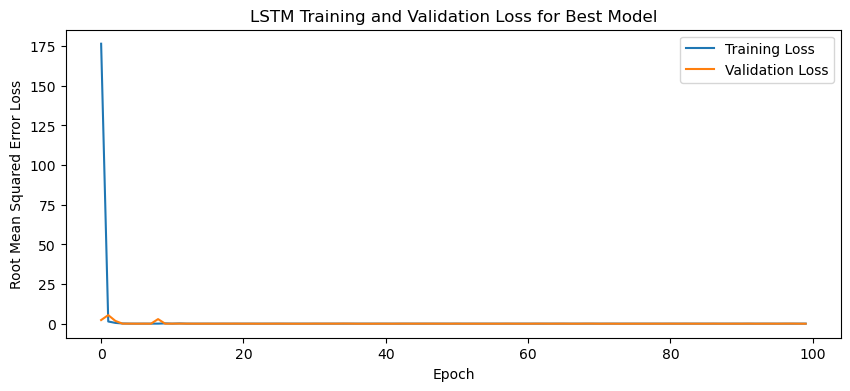

1/1 - 2s - loss: 0.1549 - 2s/epoch - 2s/step
Test Loss: 0.1548972725868225
Fold 2:
Epoch 1/100
19/19 [==============================] - 12s 213ms/step - loss: 178.0440 - val_loss: 0.3588
Epoch 2/100
19/19 [==============================] - 1s 66ms/step - loss: 0.4695 - val_loss: 0.0586
Epoch 3/100
19/19 [==============================] - 1s 65ms/step - loss: 1.0784 - val_loss: 0.1806
Epoch 4/100
19/19 [==============================] - 1s 65ms/step - loss: 0.1115 - val_loss: 0.1251
Epoch 5/100
19/19 [==============================] - 1s 70ms/step - loss: 0.1104 - val_loss: 0.1079
Epoch 6/100
19/19 [==============================] - 2s 81ms/step - loss: 0.1097 - val_loss: 0.0850
Epoch 7/100
19/19 [==============================] - 2s 81ms/step - loss: 0.1135 - val_loss: 0.0842
Epoch 8/100
19/19 [==============================] - 2s 91ms/step - loss: 0.1094 - val_loss: 0.0623
Epoch 9/100
19/19 [==============================] - 2s 126ms/step - loss: 0.0991 - val_loss: 0.0817
Epoch 10/100

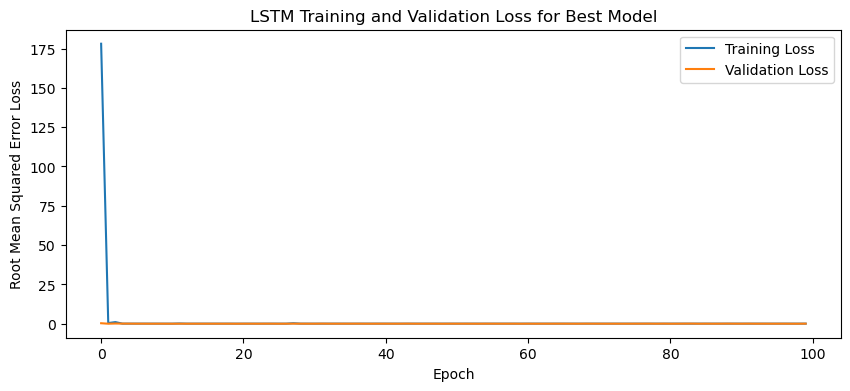

1/1 - 3s - loss: 0.1426 - 3s/epoch - 3s/step
Test Loss: 0.1425599604845047
Fold 3:
Epoch 1/100
19/19 [==============================] - 11s 170ms/step - loss: 176.4936 - val_loss: 0.5104
Epoch 2/100
19/19 [==============================] - 1s 65ms/step - loss: 0.2884 - val_loss: 0.1136
Epoch 3/100
19/19 [==============================] - 1s 64ms/step - loss: 0.4482 - val_loss: 0.1338
Epoch 4/100
19/19 [==============================] - 1s 61ms/step - loss: 0.1725 - val_loss: 0.1284
Epoch 5/100
19/19 [==============================] - 1s 62ms/step - loss: 0.1134 - val_loss: 0.0966
Epoch 6/100
19/19 [==============================] - 1s 57ms/step - loss: 0.3368 - val_loss: 0.0582
Epoch 7/100
19/19 [==============================] - 1s 66ms/step - loss: 0.2299 - val_loss: 3.3749
Epoch 8/100
19/19 [==============================] - 1s 62ms/step - loss: 0.2905 - val_loss: 0.0622
Epoch 9/100
19/19 [==============================] - 1s 70ms/step - loss: 0.1010 - val_loss: 0.0848
Epoch 10/100


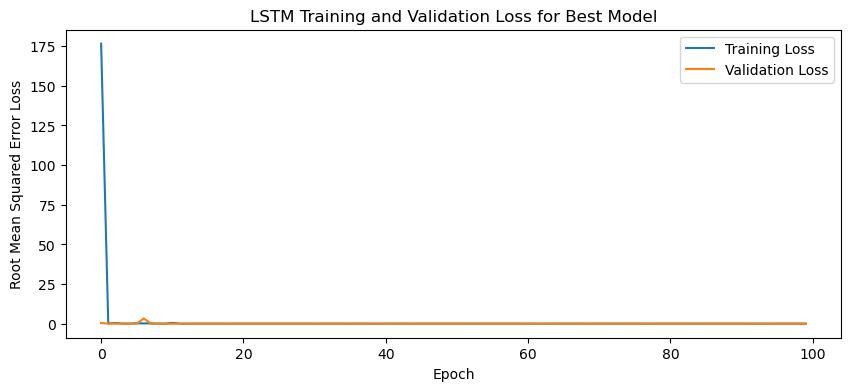

1/1 - 3s - loss: 0.0990 - 3s/epoch - 3s/step
Test Loss: 0.09897666424512863
Fold 4:
Epoch 1/100
20/20 [==============================] - 11s 182ms/step - loss: 200.6901 - val_loss: 2.7190
Epoch 2/100
20/20 [==============================] - 1s 72ms/step - loss: 0.6528 - val_loss: 0.1139
Epoch 3/100
20/20 [==============================] - 1s 52ms/step - loss: 0.1464 - val_loss: 0.1907
Epoch 4/100
20/20 [==============================] - 1s 70ms/step - loss: 0.1053 - val_loss: 0.2009
Epoch 5/100
20/20 [==============================] - 1s 65ms/step - loss: 0.1882 - val_loss: 0.1523
Epoch 6/100
20/20 [==============================] - 1s 62ms/step - loss: 0.0953 - val_loss: 0.1539
Epoch 7/100
20/20 [==============================] - 1s 64ms/step - loss: 0.0926 - val_loss: 0.0542
Epoch 8/100
20/20 [==============================] - 1s 63ms/step - loss: 0.1044 - val_loss: 0.1178
Epoch 9/100
20/20 [==============================] - 1s 65ms/step - loss: 0.0954 - val_loss: 0.1469
Epoch 10/100

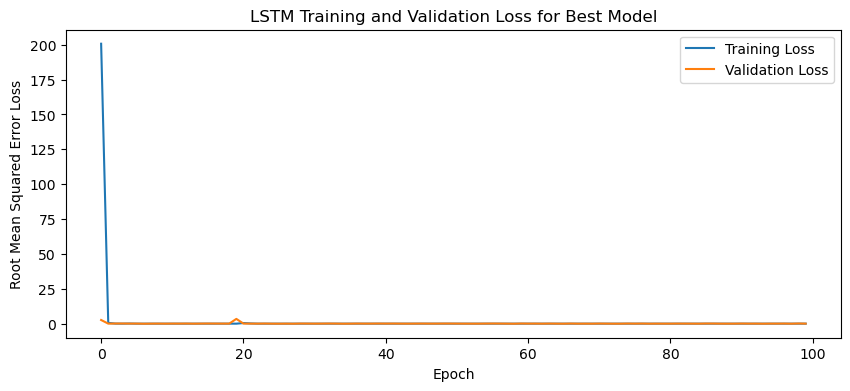

1/1 - 2s - loss: 0.0971 - 2s/epoch - 2s/step
Test Loss: 0.09709716588258743
Fold 5:
Epoch 1/100
19/19 [==============================] - 11s 166ms/step - loss: 191.3225 - val_loss: 0.8179
Epoch 2/100
19/19 [==============================] - 1s 48ms/step - loss: 0.4551 - val_loss: 0.3393
Epoch 3/100
19/19 [==============================] - 1s 42ms/step - loss: 0.2491 - val_loss: 0.1426
Epoch 4/100
19/19 [==============================] - 1s 54ms/step - loss: 0.1343 - val_loss: 0.1711
Epoch 5/100
19/19 [==============================] - 1s 52ms/step - loss: 0.0952 - val_loss: 0.1698
Epoch 6/100
19/19 [==============================] - 1s 78ms/step - loss: 0.4915 - val_loss: 0.1512
Epoch 7/100
19/19 [==============================] - 1s 50ms/step - loss: 0.1412 - val_loss: 0.1614
Epoch 8/100
19/19 [==============================] - 1s 50ms/step - loss: 0.1053 - val_loss: 0.1152
Epoch 9/100
19/19 [==============================] - 1s 59ms/step - loss: 0.7491 - val_loss: 0.1589
Epoch 10/100

In [ ]:
n_batch = 1
nb_epoch = 100

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
 
# fit an LSTM network to training data
#Adapted from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch):

    cv_accuracies = []
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters to be tuned by Optuna (taken from Javier Leon's dissertation 'Fruit Prices')
    lr = trial.suggest_float('lr', 1e-3, 1, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])
    if optimizer_name == 'Adam':
        optimizer = Adam(learning_rate=lr)
    elif optimizer_name == 'RMSprop':
        optimizer = RMSprop(learning_rate=lr)
    else:
        optimizer = SGD(learning_rate=lr)
    
    #Optuna will try either Rectified Linear Unit (ReLU) = max(0, x), tanh, or sigmoid functions
    activation_function = trial.suggest_categorical('activation_function', ['relu', 'tanh', 'sigmoid'])
    
    lstm_units = trial.suggest_categorical('lstm_units', [256, 512, 1024])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)

    # design network
    model = Sequential()
    model.add(LSTM(lstm_units, return_sequences=True, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer)
        
    return model
    
def objective(trial):
    
    cv_accuracies = []
        
    for i in range(5):
        train1 = train[i]
        test1 = test[i]
        validation1 = validation[i]

        X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
        X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
        X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq:]
        X = X.reshape(X.shape[0], 1, X.shape[1])
        X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
        X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
    
        model = create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch)

        history = model.fit(X, y, validation_data=(X_val, y_val), epochs=nb_epoch, verbose=0)

        cv_accuracy = model.evaluate(X_test, y_test, verbose=0)
    
        loss = history.history['val_loss'][-1]
    
        # Plotting the training and validation loss
        #plt.figure(figsize=(10, 4))
        #plt.plot(history.history['loss'], label='Training Loss')
        #plt.plot(history.history['val_loss'], label='Validation Loss')
        #title1 = "LSTM Training and Validation Loss for Fold " + str(i+1)
        #plt.title(title1)
        #plt.xlabel('Epoch')
        #plt.ylabel('Root Mean Squared Error Loss')
        #plt.legend()
        #plt.show()
            
        cv_accuracies.append(cv_accuracy)
    
    print("Cross Validation Accuracies:")
    print(cv_accuracies)
    print("Mean Cross Validation Accuracy:")
    print(np.mean(cv_accuracies))
    print("Standard Deviation of Cross Validation Accuracy:")
    print(np.std(cv_accuracies))
        
    return np.mean(cv_accuracies)

n_batch = 1
nb_epoch = 100

# optimize and fit model
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
print('Number of finished trials:', len(study.trials))

print('Best trial:', study.best_trial.params)
best_params = study.best_params
print("Best hyperparameters: ", best_params)

for i in range(5):
    print("Fold "+str(i+1)+":")
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
    X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
    X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_model(optuna.trial.FixedTrial(best_params), X, y, n_lag, n_seq, n_batch, nb_epoch)
    history = best_model.fit(X, y, epochs=100, batch_size=n_batch, validation_data=(X_val, y_val))

    # Plotting the training and validation loss
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title1 = "LSTM Training and Validation Loss for Best Model"
    plt.title(title1)
    plt.xlabel('Epoch')
    plt.ylabel('Root Mean Squared Error Loss')
    plt.legend()
    plt.show()

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

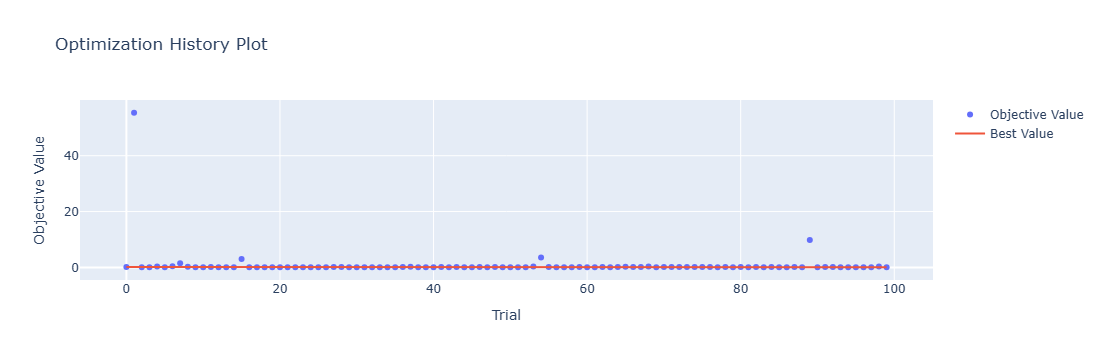

In [7]:
optuna.visualization.plot_optimization_history(study)

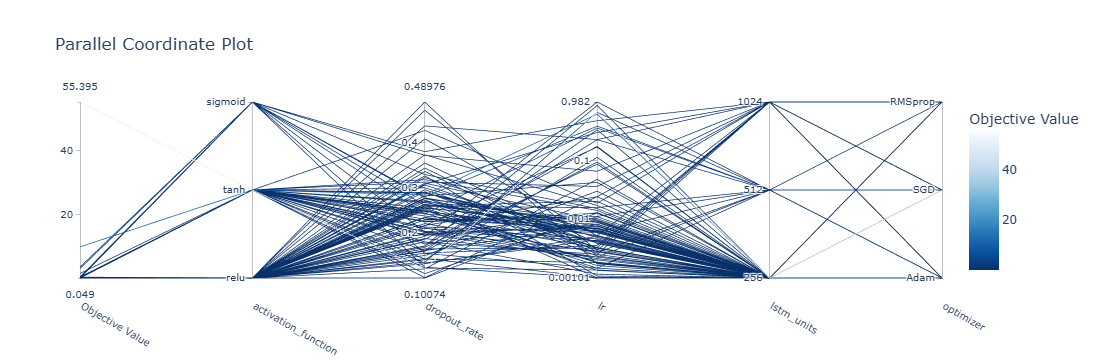

In [8]:
optuna.visualization.plot_parallel_coordinate(study)

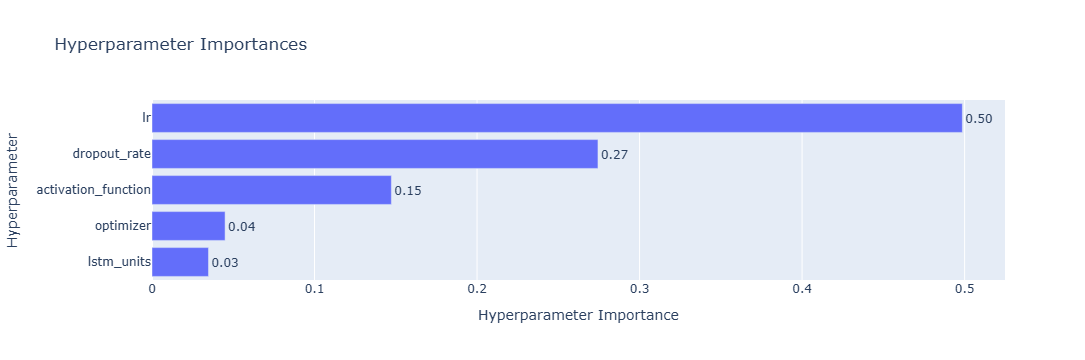

In [9]:
optuna.visualization.plot_param_importances(study)

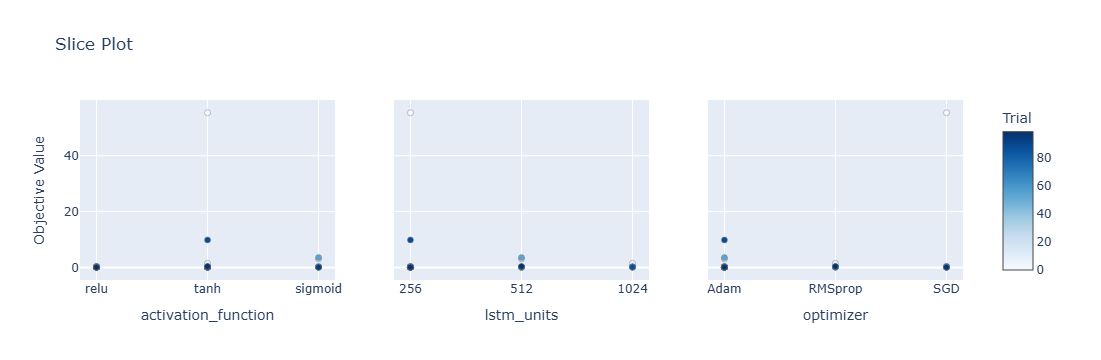

In [10]:
optuna.visualization.plot_slice(study, params=['optimizer', 'activation_function', 'lstm_units'])

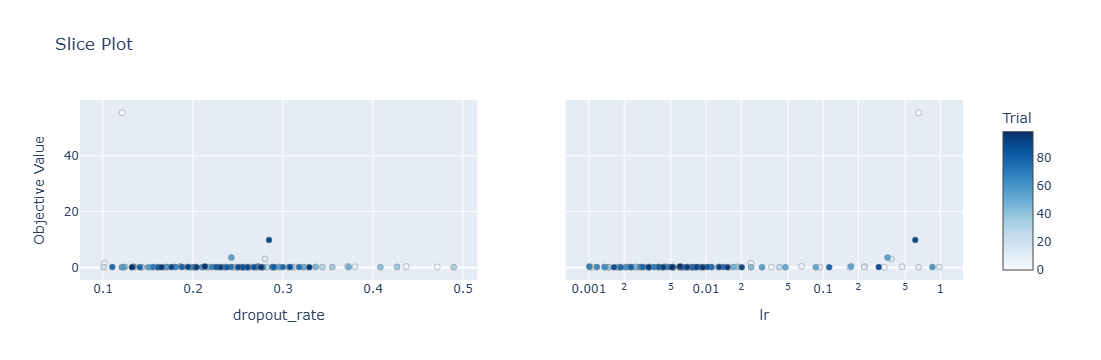

In [11]:
optuna.visualization.plot_slice(study, params=['lr', 'dropout_rate'])

[[20.84 20.69 20.47 20.3  20.46 20.31 20.43 20.63 21.05 20.79 20.3  20.47
  19.79 21.11 21.38 20.92 20.47 21.77 22.5  22.86 21.64 21.57 21.74 21.57
  21.81 22.23 22.62]
 [16.57 15.99 15.39 15.45 15.98 15.45 15.57 15.59 15.96 16.16 15.83 15.88
  15.64 16.44 17.   15.83 15.63 16.9  17.06 17.3  17.26 18.21 17.38 16.87
  17.15 16.98 18.47]]
Epoch 1/100
19/19 [==============================] - 5s 68ms/step - loss: 0.2951 - accuracy: 0.4211 - mae: 0.2670 - rmse: 0.2951 - mape: 46.8700 - pearson: 0.3271 - val_loss: 0.0935 - val_accuracy: 0.6667 - val_mae: 0.0766 - val_rmse: 0.0935 - val_mape: 12.9313 - val_pearson: 0.7084
Epoch 2/100
19/19 [==============================] - 0s 8ms/step - loss: 0.1752 - accuracy: 0.6316 - mae: 0.1531 - rmse: 0.1752 - mape: 28.0188 - pearson: 0.3551 - val_loss: 0.1618 - val_accuracy: 0.0000e+00 - val_mae: 0.1450 - val_rmse: 0.1618 - val_mape: 26.7810 - val_pearson: 0.5512
Epoch 3/100
19/19 [==============================] - 0s 8ms/step - loss: 0.1649 - accuracy

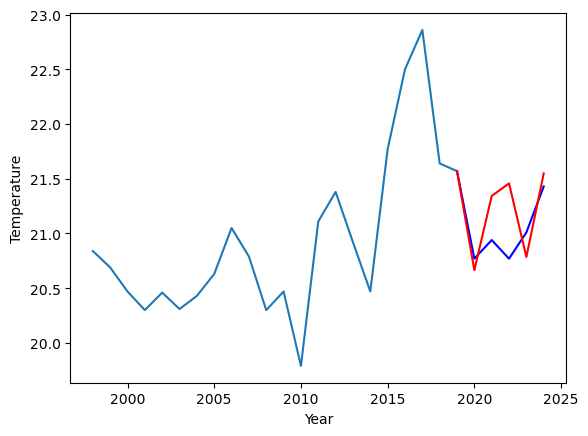

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
17.52		16.40		-1.12
16.69		17.03		0.34
16.18		17.12		0.94
16.46		16.46		0.00
16.29		17.20		0.91


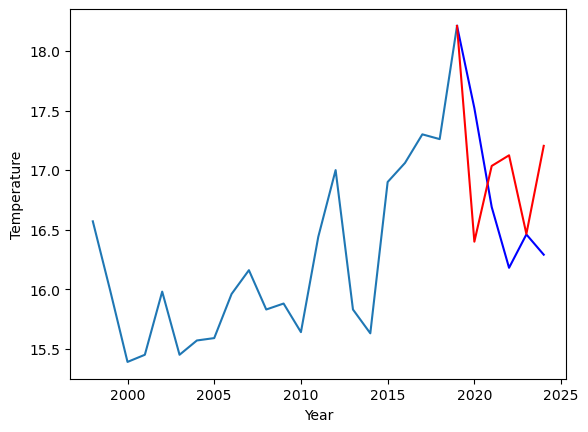

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   20.77  20.664891
1                1   17.52  16.399369


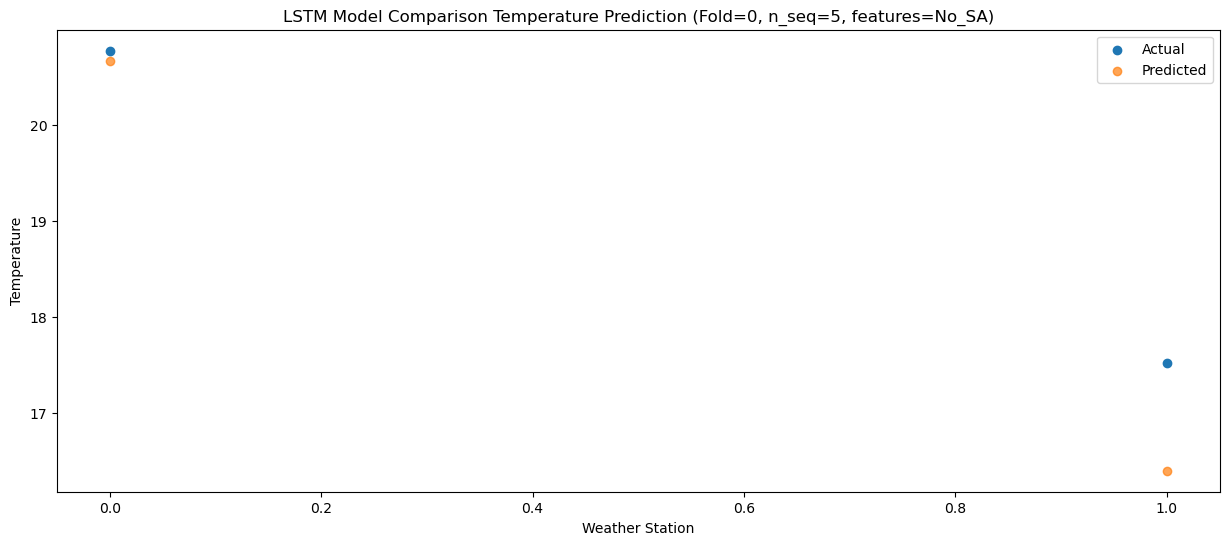

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   20.94  21.342749
1                1   16.69  17.034788


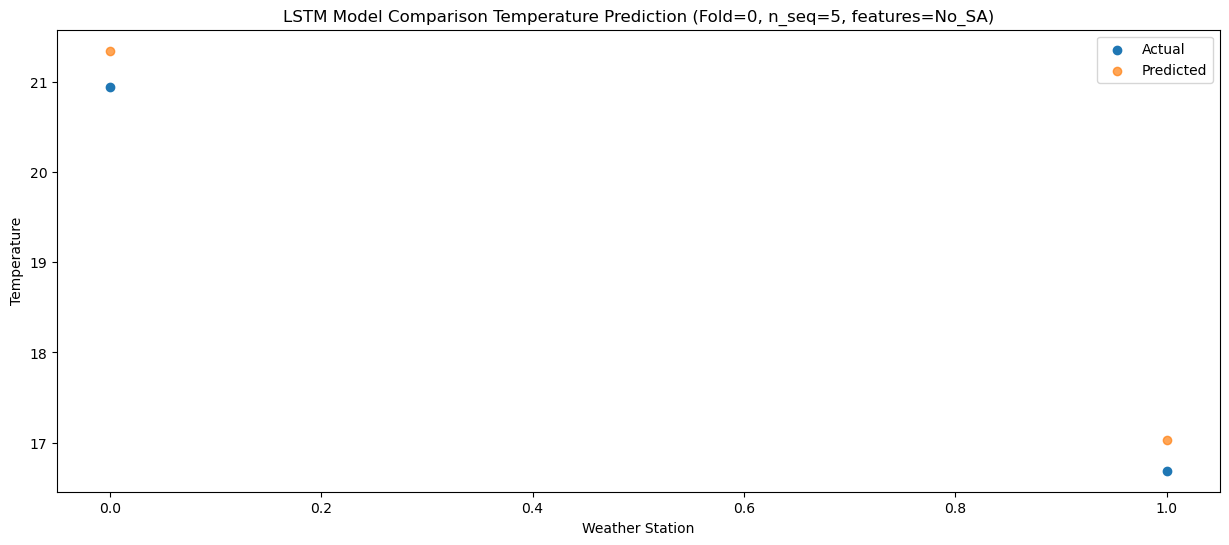

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   20.77  21.457814
1                1   16.18  17.124115


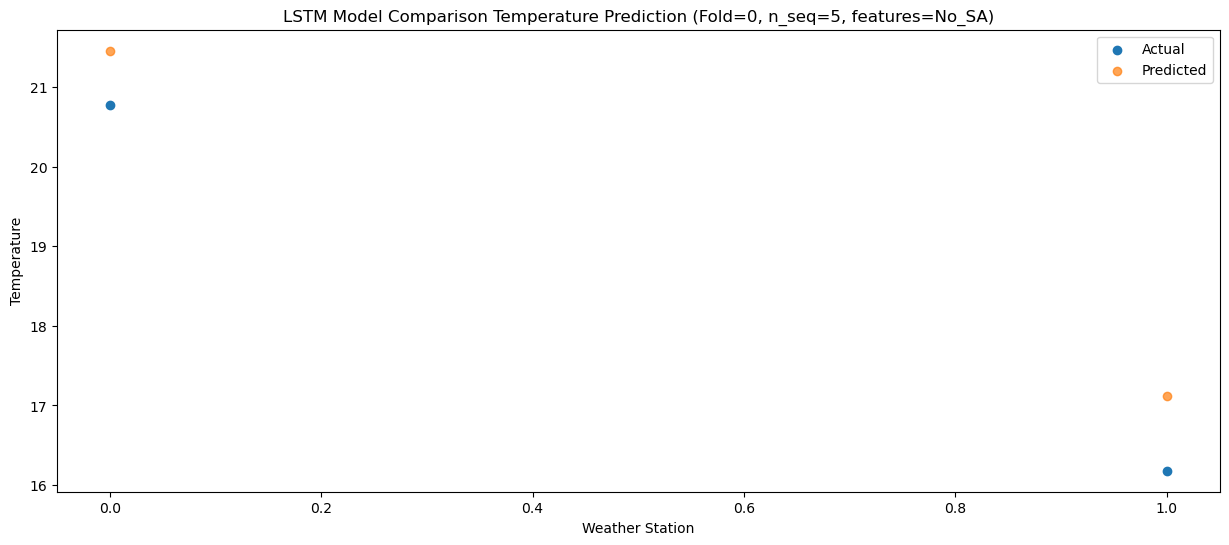

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   21.01  20.785422
1                1   16.46  16.464304


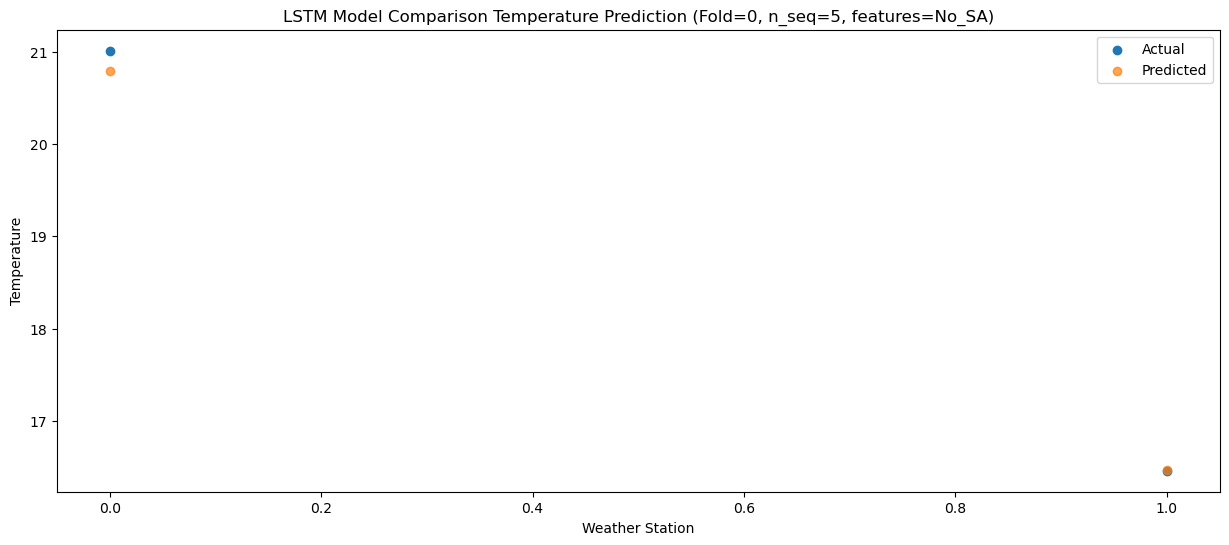

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   21.43  21.549303
1                1   16.29  17.203489


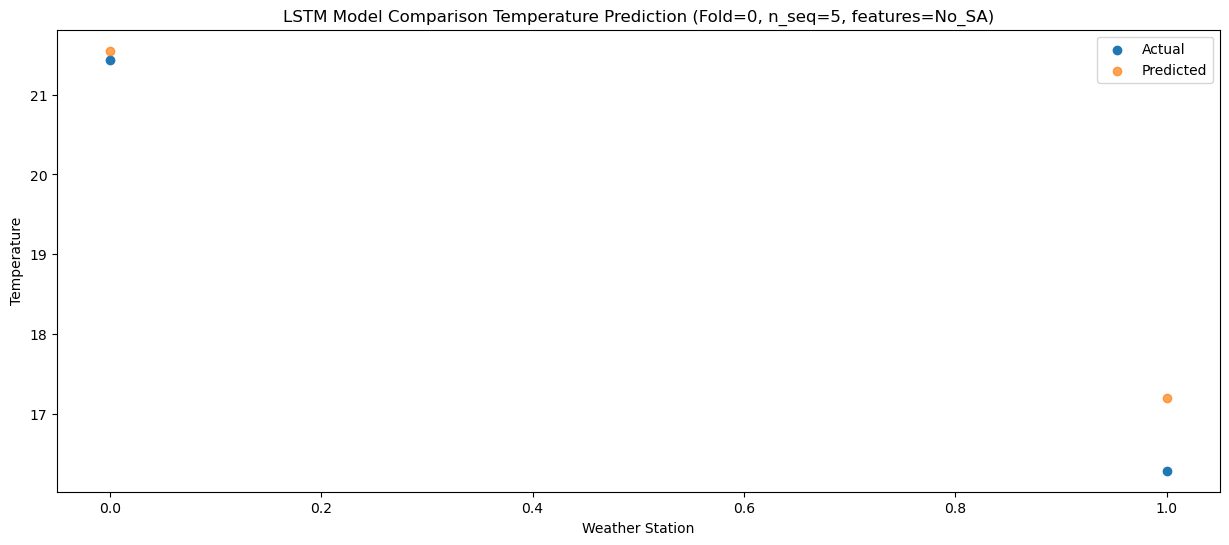

f, t:
[[20.77 17.52]
 [20.94 16.69]
 [20.77 16.18]
 [21.01 16.46]
 [21.43 16.29]]
[[20.66489051 16.39936892]
 [21.34274928 17.03478805]
 [21.45781423 17.12411483]
 [20.7854215  16.4643041 ]
 [21.54930319 17.20348866]]
Year at t+1:
t+1 SKRMSE: 0.795884
t+1 KRMSE: 0.795884
t+1 MAE: 0.612870
t+1 SKMAPE: 0.034512
t+1 R2_SCORE: 0.760121
t+1 KMAPE: 0.034512
t+1 PEARSON: 1.000000
Year at t+2:
t+2 SKRMSE: 0.374891
t+2 KRMSE: 0.374891
t+2 MAE: 0.373769
t+2 SKMAPE: 0.019946
t+2 R2_SCORE: 0.968876
t+2 KMAPE: 0.019946
t+2 PEARSON: 1.000000
Year at t+3:
t+3 SKRMSE: 0.825966
t+3 KRMSE: 0.825966
t+3 MAE: 0.815965
t+3 SKMAPE: 0.045733
t+3 R2_SCORE: 0.870473
t+3 KMAPE: 0.045733
t+3 PEARSON: 1.000000
Year at t+4:
t+4 SKRMSE: 0.158830
t+4 KRMSE: 0.158830
t+4 MAE: 0.114441
t+4 SKMAPE: 0.005475
t+4 R2_SCORE: 0.995126
t+4 KMAPE: 0.005475
t+4 PEARSON: 1.000000
Year at t+5:
t+5 SKRMSE: 0.651420
t+5 KRMSE: 0.651420
t+5 MAE: 0.516396
t+5 SKMAPE: 0.030822
t+5 R2_SCORE: 0.935753
t+5 KMAPE: 0.030822
t+5 PEARSON: 1

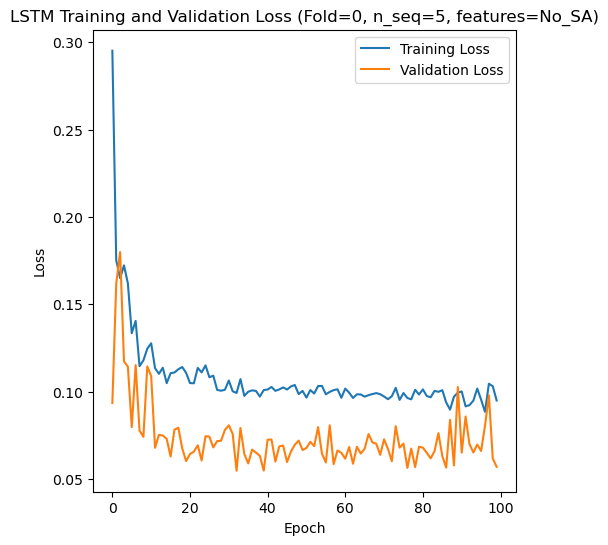

[[19.54 18.69 17.98 18.61 18.9  18.32 18.53 18.52 18.91 19.16 18.59 18.48
  18.2  19.26 19.25 18.86 18.95 19.48 19.77 19.73 19.56 19.64 19.73 18.81
  19.15 19.99 20.79]
 [19.69 19.59 19.68 19.6  19.14 19.33 18.41 19.15 20.48 18.58 19.32 19.44
  18.75 20.43 20.08 18.77 18.96 18.48 19.51 19.89 19.04 19.17 19.69 19.3
  19.3  20.61 21.9 ]]
Epoch 1/100
19/19 [==============================] - 5s 70ms/step - loss: 0.2990 - accuracy: 0.3684 - mae: 0.2721 - rmse: 0.2990 - mape: 43.3255 - pearson: 0.3752 - val_loss: 0.1910 - val_accuracy: 0.0000e+00 - val_mae: 0.1664 - val_rmse: 0.1910 - val_mape: 25.8171 - val_pearson: 0.0363
Epoch 2/100
19/19 [==============================] - 0s 8ms/step - loss: 0.1498 - accuracy: 0.4737 - mae: 0.1271 - rmse: 0.1498 - mape: 20.9385 - pearson: 0.4807 - val_loss: 0.1393 - val_accuracy: 0.0000e+00 - val_mae: 0.1175 - val_rmse: 0.1393 - val_mape: 17.5637 - val_pearson: 0.0419
Epoch 3/100
19/19 [==============================] - 0s 8ms/step - loss: 0.1491 - accur

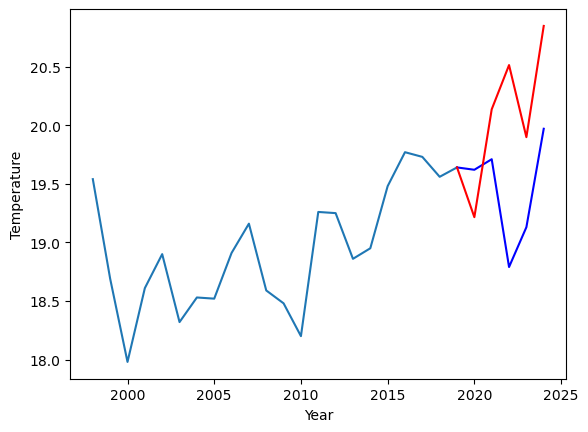

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
19.82		19.24		-0.58
20.34		20.28		-0.06
19.95		20.69		0.74
19.95		19.90		-0.05
21.26		20.92		-0.34


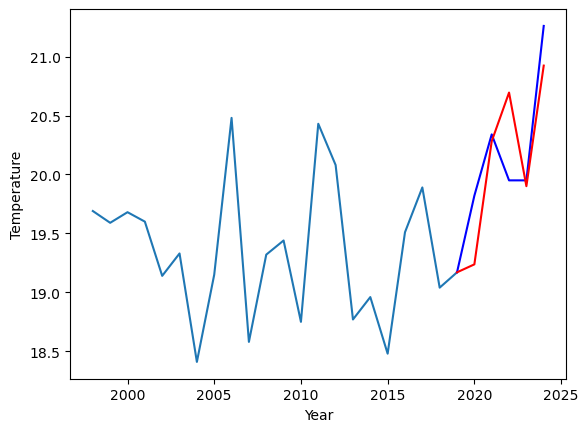

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   19.62  19.215427
1                1   19.82  19.237489


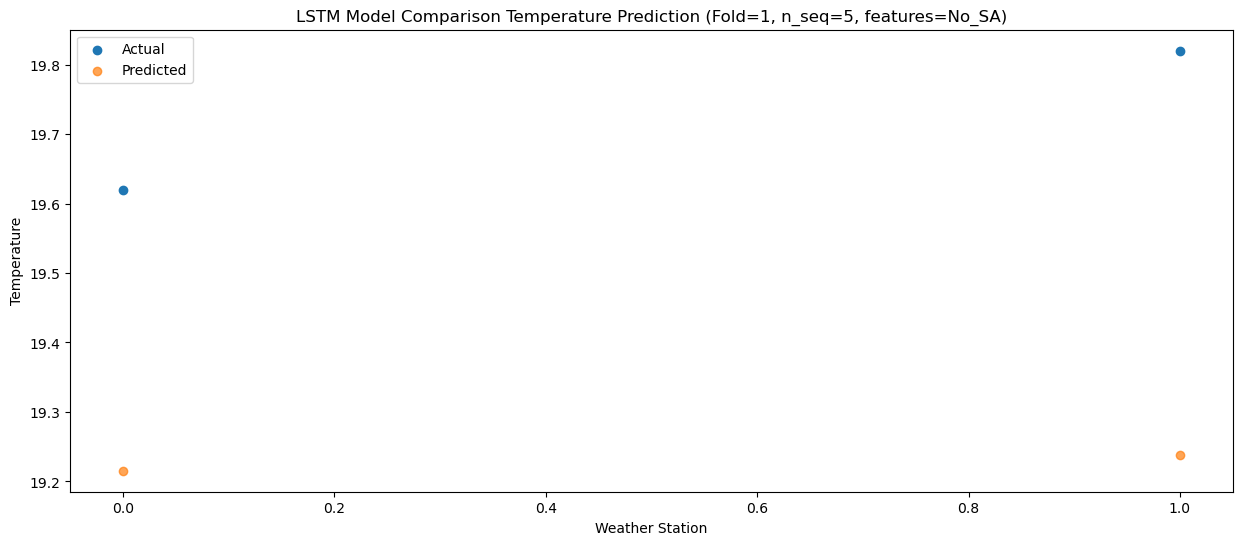

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   19.71  20.135824
1                1   20.34  20.281683


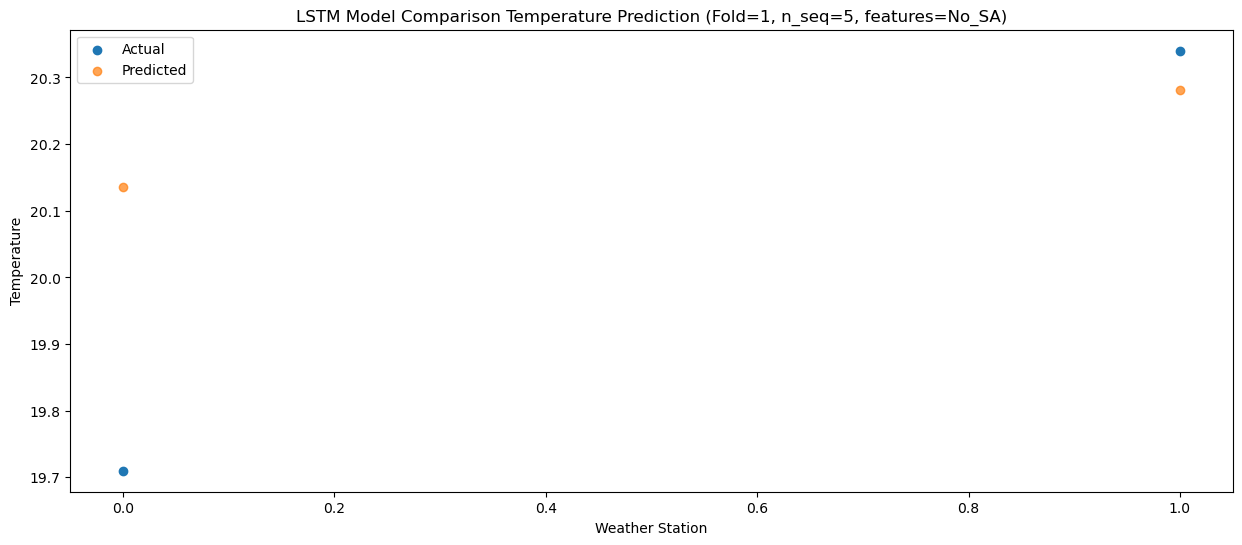

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   18.79  20.513482
1                1   19.95  20.694638


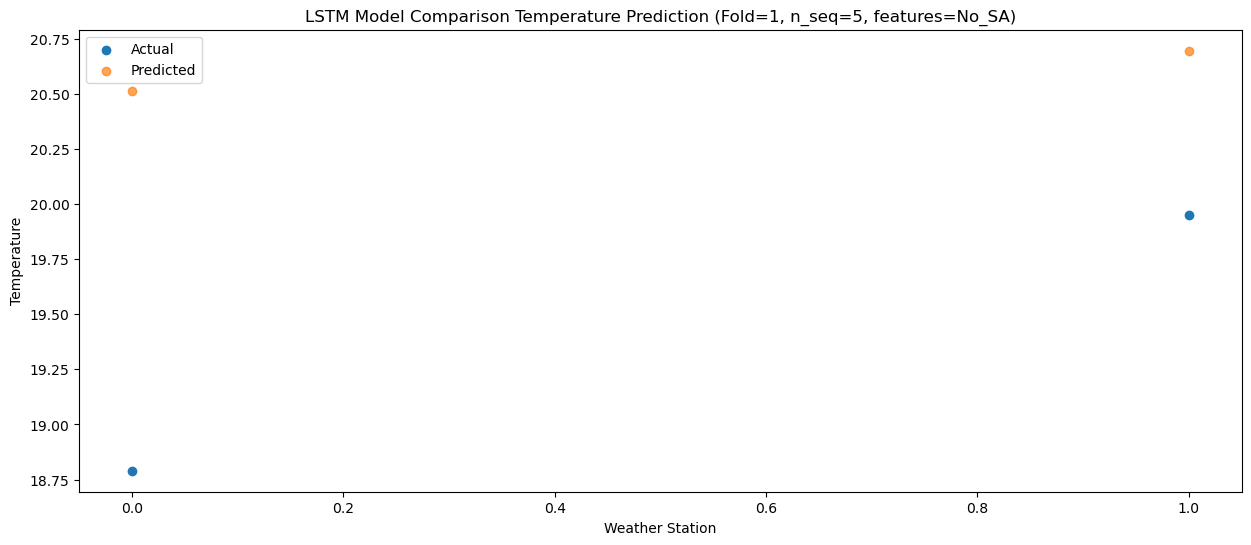

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   19.13  19.898205
1                1   19.95  19.900765


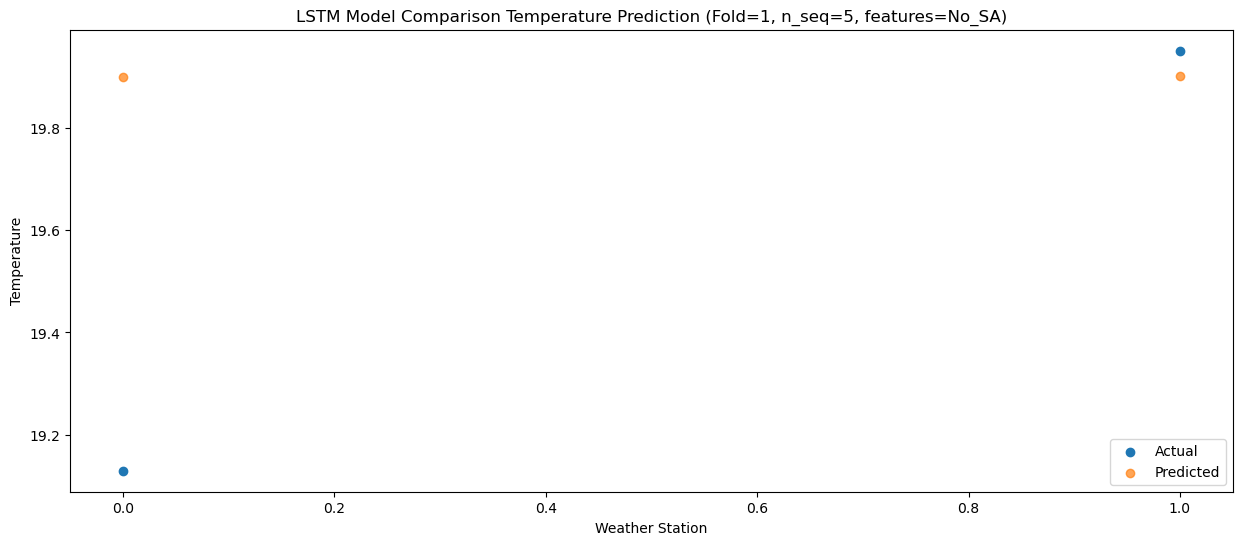

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   19.97  20.847696
1                1   21.26  20.923497


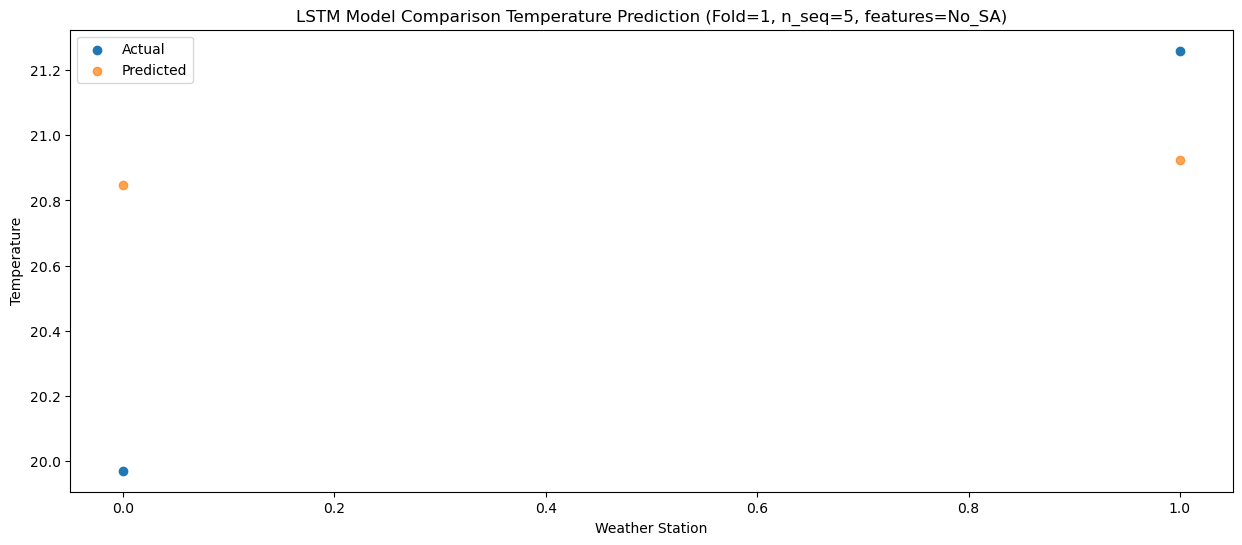

f, t:
[[19.62 19.82]
 [19.71 20.34]
 [18.79 19.95]
 [19.13 19.95]
 [19.97 21.26]]
[[19.21542708 19.23748851]
 [20.13582418 20.28168345]
 [20.51348192 20.69463849]
 [19.89820529 19.90076459]
 [20.84769613 20.92349744]]
Year at t+1:
t+1 SKRMSE: 0.501497
t+1 KRMSE: 0.501497
t+1 MAE: 0.493542
t+1 SKMAPE: 0.025005
t+1 R2_SCORE: -24.149944
t+1 KMAPE: 0.025005
t+1 PEARSON: 1.000000
Year at t+2:
t+2 SKRMSE: 0.303914
t+2 KRMSE: 0.303914
t+2 MAE: 0.242070
t+2 SKMAPE: 0.012236
t+2 R2_SCORE: 0.069151
t+2 KMAPE: 0.012236
t+2 PEARSON: 1.000000
Year at t+3:
t+3 SKRMSE: 1.327569
t+3 KRMSE: 1.327569
t+3 MAE: 1.234060
t+3 SKMAPE: 0.064524
t+3 R2_SCORE: -4.239115
t+3 KMAPE: 0.064524
t+3 PEARSON: 1.000000
Year at t+4:
t+4 SKRMSE: 0.544318
t+4 KRMSE: 0.544318
t+4 MAE: 0.408720
t+4 SKMAPE: 0.021313
t+4 R2_SCORE: -0.762533
t+4 KMAPE: 0.021313
t+4 PEARSON: 1.000000
Year at t+5:
t+5 SKRMSE: 0.664675
t+5 KRMSE: 0.664675
t+5 MAE: 0.607099
t+5 SKMAPE: 0.029889
t+5 R2_SCORE: -0.061937
t+5 KMAPE: 0.029889
t+5 PEARS

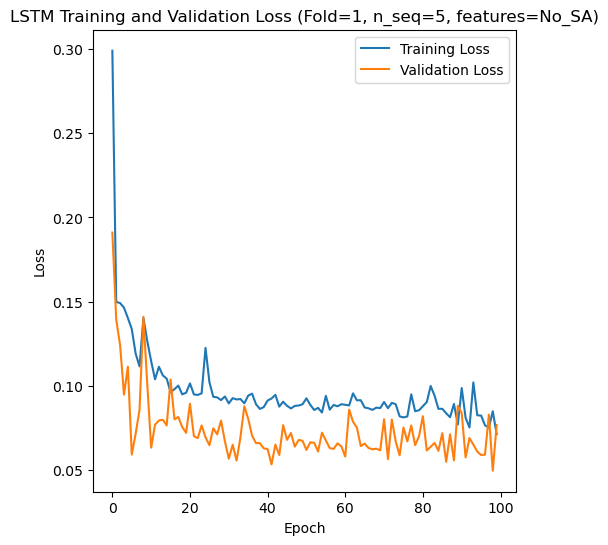

[[16.84 16.42 15.63 15.84 16.01 15.21 15.86 15.86 16.6  17.15 15.61 15.43
  15.69 16.61 16.97 15.29 15.43 16.62 17.18 16.96 16.33 17.09 16.39 16.63
  16.6  17.04 18.25]
 [13.51 12.74 11.83 12.67 12.83 11.71 12.25 12.85 13.05 13.49 12.15 12.07
  12.6  13.05 14.02 12.15 11.53 12.87 13.64 13.46 12.99 13.32 13.31 13.3
  12.84 13.63 15.32]]
Epoch 1/100
19/19 [==============================] - 5s 67ms/step - loss: 0.2858 - accuracy: 0.3158 - mae: 0.2519 - rmse: 0.2858 - mape: 40.2417 - pearson: 0.2252 - val_loss: 0.1038 - val_accuracy: 0.3333 - val_mae: 0.0835 - val_rmse: 0.1038 - val_mape: 13.1980 - val_pearson: 0.5568
Epoch 2/100
19/19 [==============================] - 0s 8ms/step - loss: 0.1503 - accuracy: 0.4737 - mae: 0.1288 - rmse: 0.1503 - mape: 20.9820 - pearson: 0.4173 - val_loss: 0.0769 - val_accuracy: 0.6667 - val_mae: 0.0648 - val_rmse: 0.0769 - val_mape: 10.8461 - val_pearson: 0.3605
Epoch 3/100
19/19 [==============================] - 0s 8ms/step - loss: 0.1501 - accuracy: 0.3

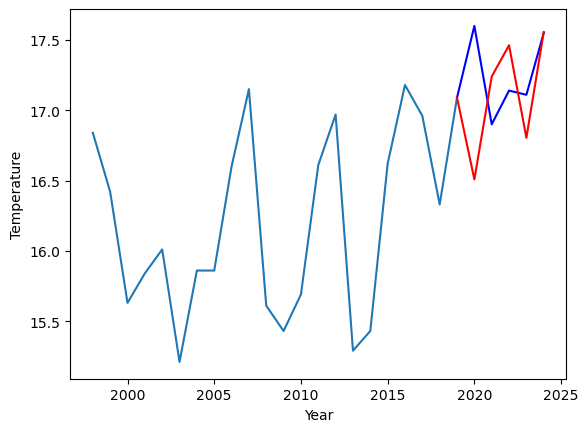

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
13.84		13.13		-0.71
13.83		13.93		0.10
13.82		14.26		0.44
13.36		13.50		0.14
14.15		14.42		0.27


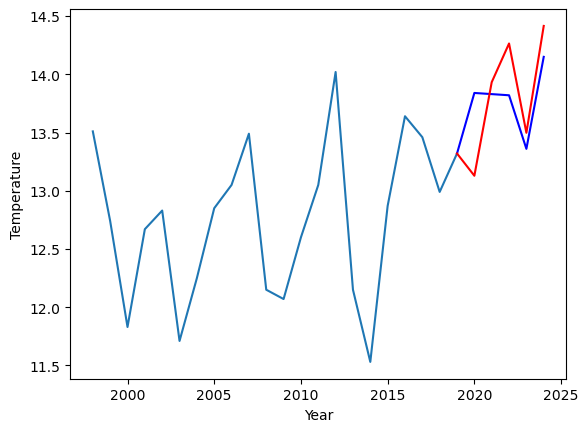

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   17.60  16.508355
1                1   13.84  13.128873


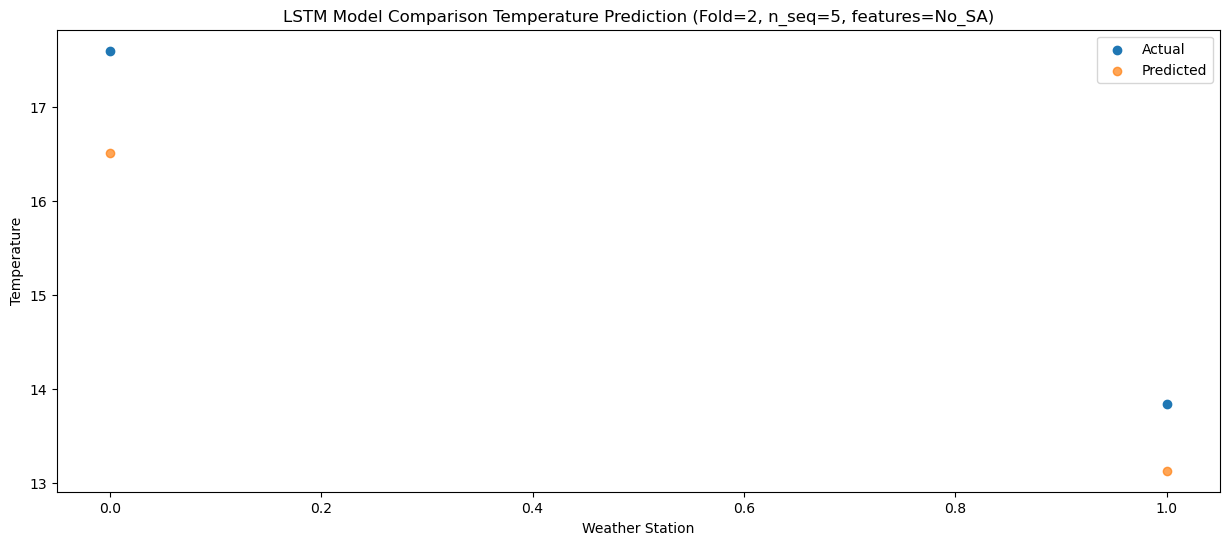

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   16.90  17.239778
1                1   13.83  13.932049


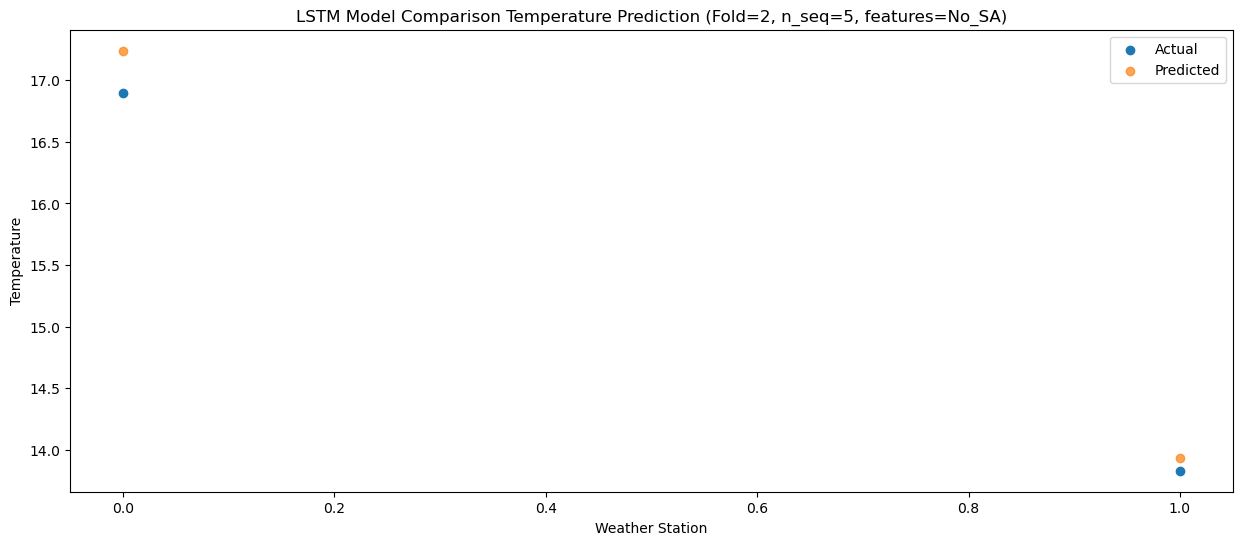

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   17.14  17.462781
1                1   13.82  14.264741


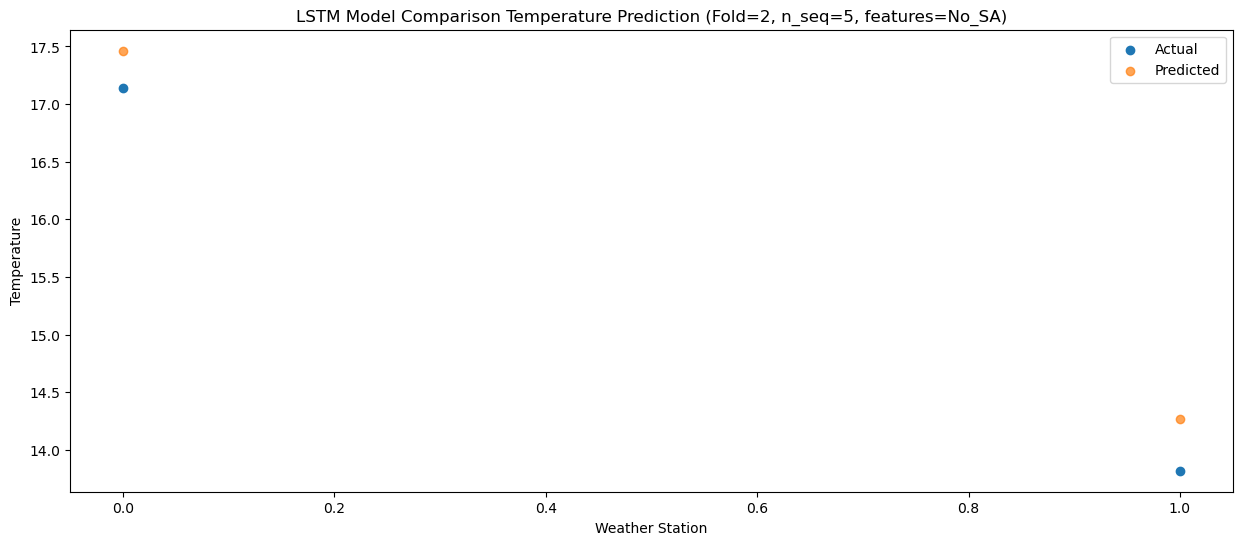

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   17.11  16.804192
1                1   13.36  13.497673


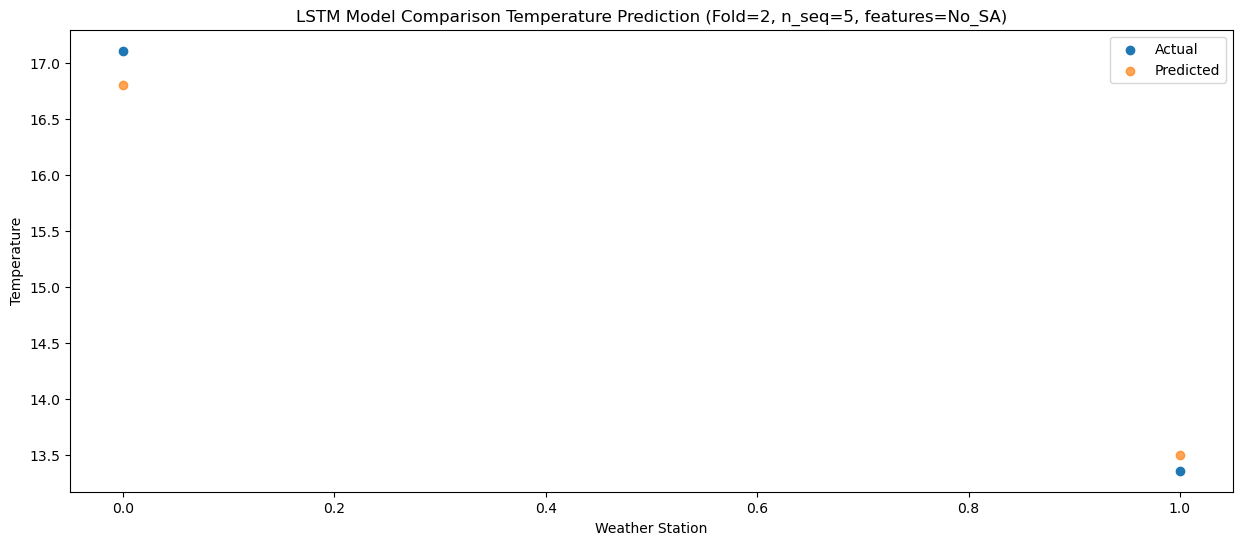

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   17.55  17.556724
1                1   14.15  14.415648


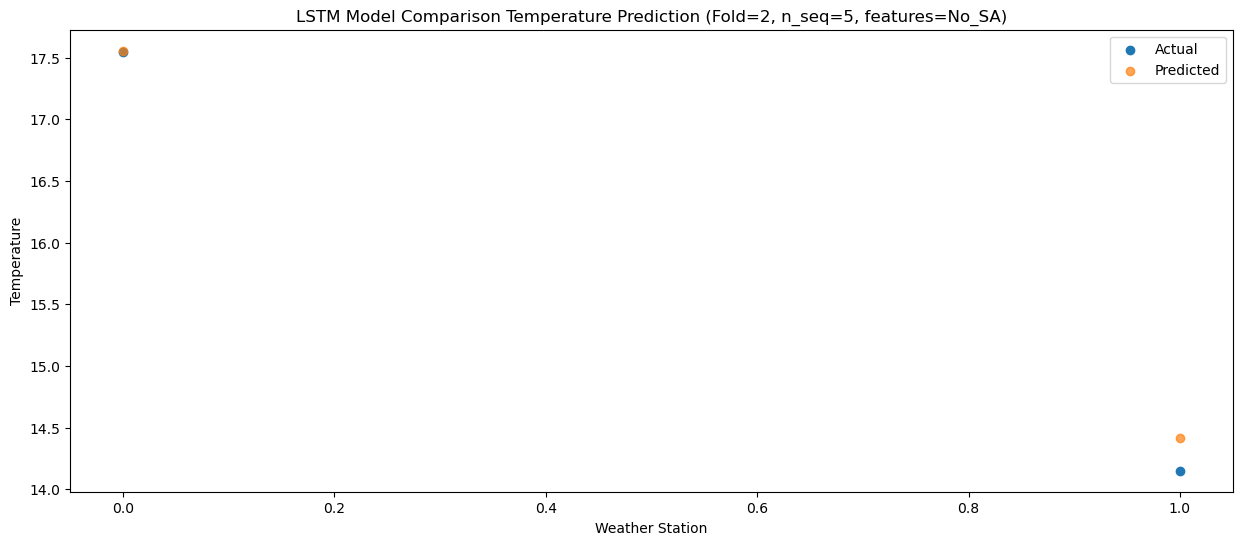

f, t:
[[17.6  13.84]
 [16.9  13.83]
 [17.14 13.82]
 [17.11 13.36]
 [17.55 14.15]]
[[16.50835487 13.12887282]
 [17.23977849 13.93204916]
 [17.46278061 14.26474119]
 [16.80419196 13.49767287]
 [17.55672355 14.41564841]]
Year at t+1:
t+1 SKRMSE: 0.921247
t+1 KRMSE: 0.921247
t+1 MAE: 0.901386
t+1 SKMAPE: 0.056704
t+1 R2_SCORE: 0.759876
t+1 KMAPE: 0.056704
t+1 PEARSON: 1.000000
Year at t+2:
t+2 SKRMSE: 0.250862
t+2 KRMSE: 0.250862
t+2 MAE: 0.220914
t+2 SKMAPE: 0.013742
t+2 R2_SCORE: 0.973291
t+2 KMAPE: 0.013742
t+2 PEARSON: 1.000000
Year at t+3:
t+3 SKRMSE: 0.388576
t+3 KRMSE: 0.388576
t+3 MAE: 0.383761
t+3 SKMAPE: 0.025506
t+3 R2_SCORE: 0.945206
t+3 KMAPE: 0.025506
t+3 PEARSON: 1.000000
Year at t+4:
t+4 SKRMSE: 0.237142
t+4 KRMSE: 0.237142
t+4 MAE: 0.221740
t+4 SKMAPE: 0.014089
t+4 R2_SCORE: 0.984004
t+4 KMAPE: 0.014089
t+4 PEARSON: 1.000000
Year at t+5:
t+5 SKRMSE: 0.187902
t+5 KRMSE: 0.187902
t+5 MAE: 0.136186
t+5 SKMAPE: 0.009578
t+5 R2_SCORE: 0.987783
t+5 KMAPE: 0.009578
t+5 PEARSON: 1

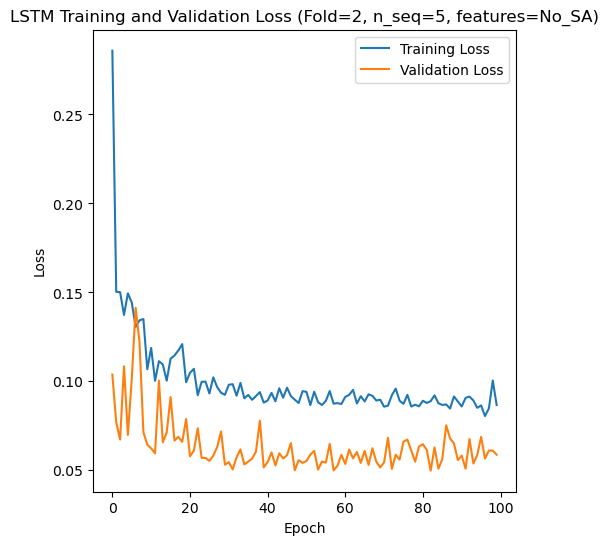

[[14.79 16.53 17.4  17.93 17.46 17.79 17.15 17.27 16.83 16.99 17.41 16.9
  16.66 16.28 17.66 17.63 19.01 18.49 18.19 18.12 18.2  17.83 17.88 18.2
  18.19 17.9  20.04]
 [14.06 13.64 12.62 13.34 13.58 12.56 13.34 13.7  13.71 13.89 12.74 12.51
  12.94 13.34 14.11 12.94 11.91 13.01 14.3  14.13 13.64 14.05 13.93 13.73
  13.43 14.45 16.49]]
Epoch 1/100
20/20 [==============================] - 5s 65ms/step - loss: 0.2767 - accuracy: 0.1500 - mae: 0.2461 - rmse: 0.2767 - mape: 38.2030 - pearson: 0.2980 - val_loss: 0.1614 - val_accuracy: 0.5000 - val_mae: 0.1302 - val_rmse: 0.1614 - val_mape: 26.1239 - val_pearson: 0.9124
Epoch 2/100
20/20 [==============================] - 0s 8ms/step - loss: 0.1942 - accuracy: 0.4000 - mae: 0.1701 - rmse: 0.1942 - mape: 26.6499 - pearson: 0.3764 - val_loss: 0.3046 - val_accuracy: 0.5000 - val_mae: 0.2710 - val_rmse: 0.3046 - val_mape: 37.3485 - val_pearson: 0.5831
Epoch 3/100
20/20 [==============================] - 0s 8ms/step - loss: 0.1972 - accuracy: 0.40

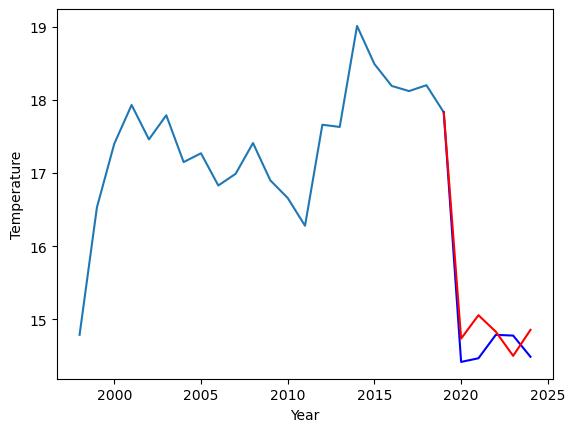

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
14.47		14.01		-0.46
14.35		14.34		-0.01
14.15		14.12		-0.03
13.85		13.79		-0.06
14.87		14.15		-0.72


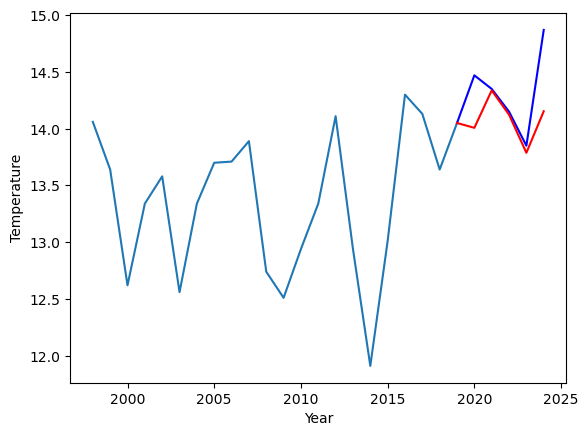

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   14.42  14.738686
1                1   14.47  14.007590


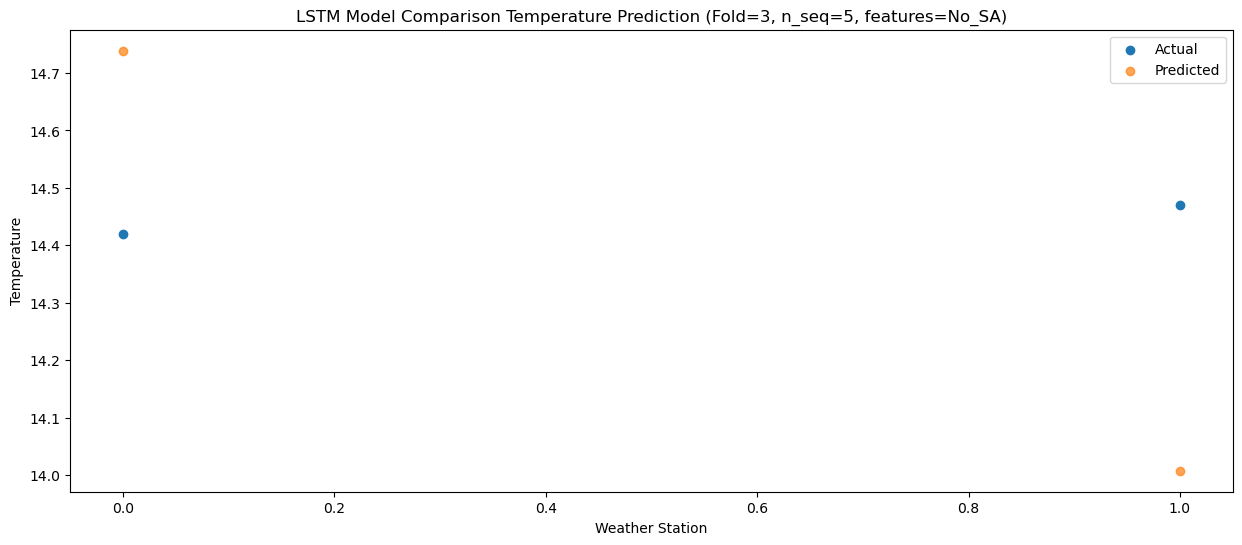

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   14.47  15.058273
1                1   14.35  14.336954


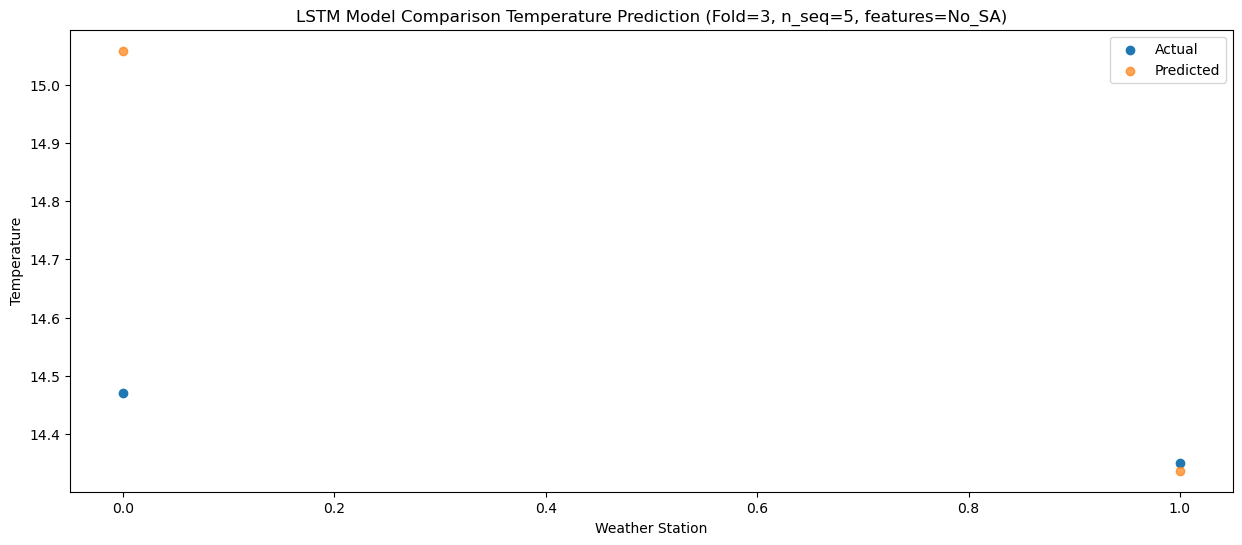

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   14.79  14.833324
1                1   14.15  14.123163


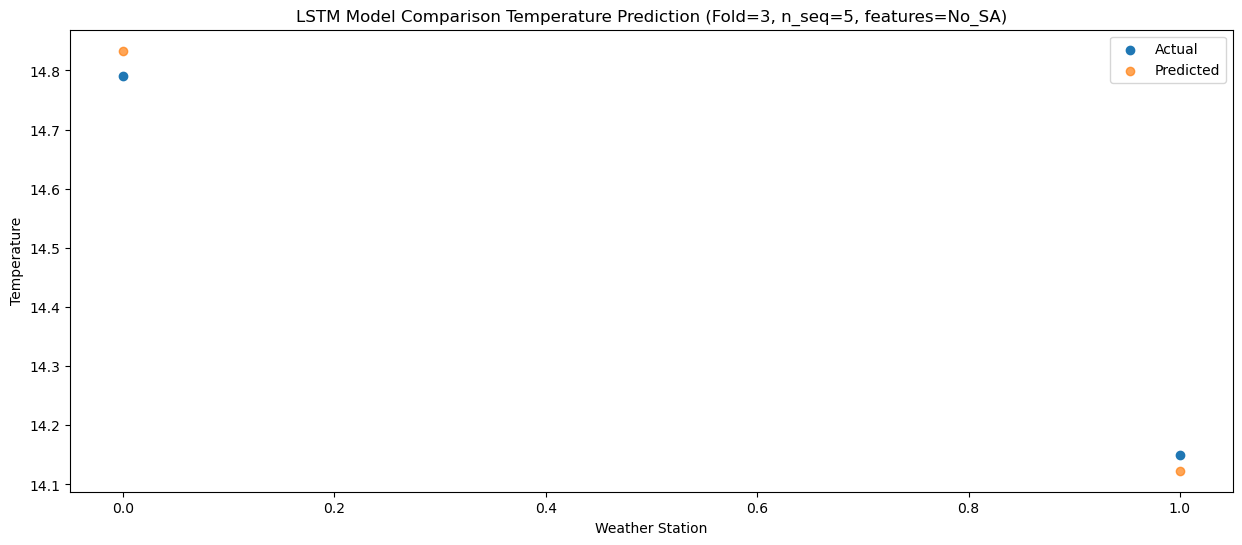

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   14.78  14.503144
1                1   13.85  13.787605


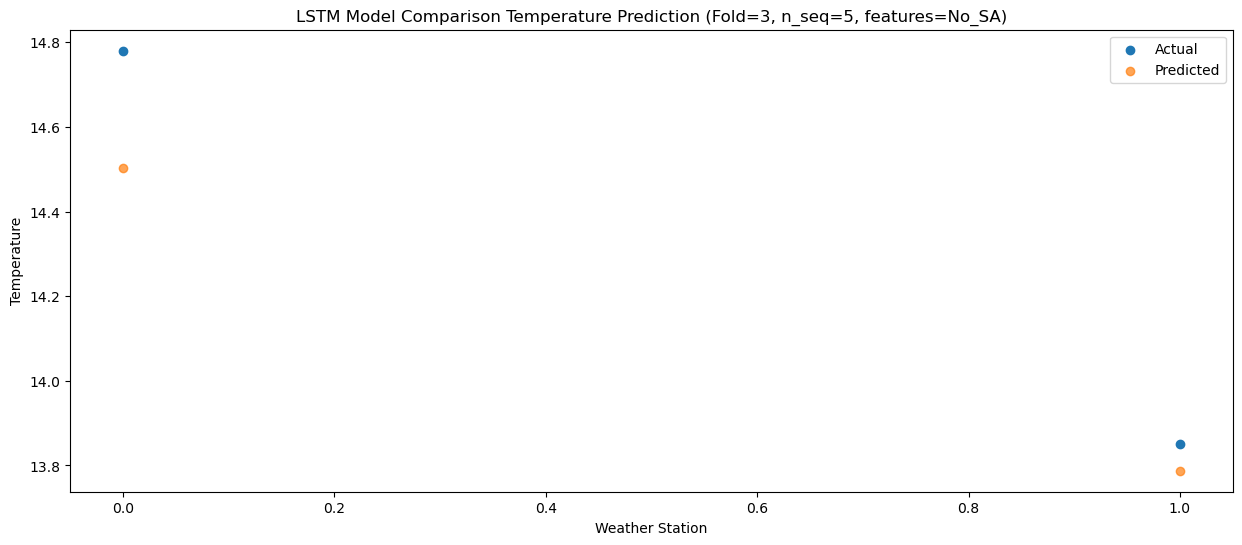

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   14.49  14.858145
1                1   14.87  14.153383


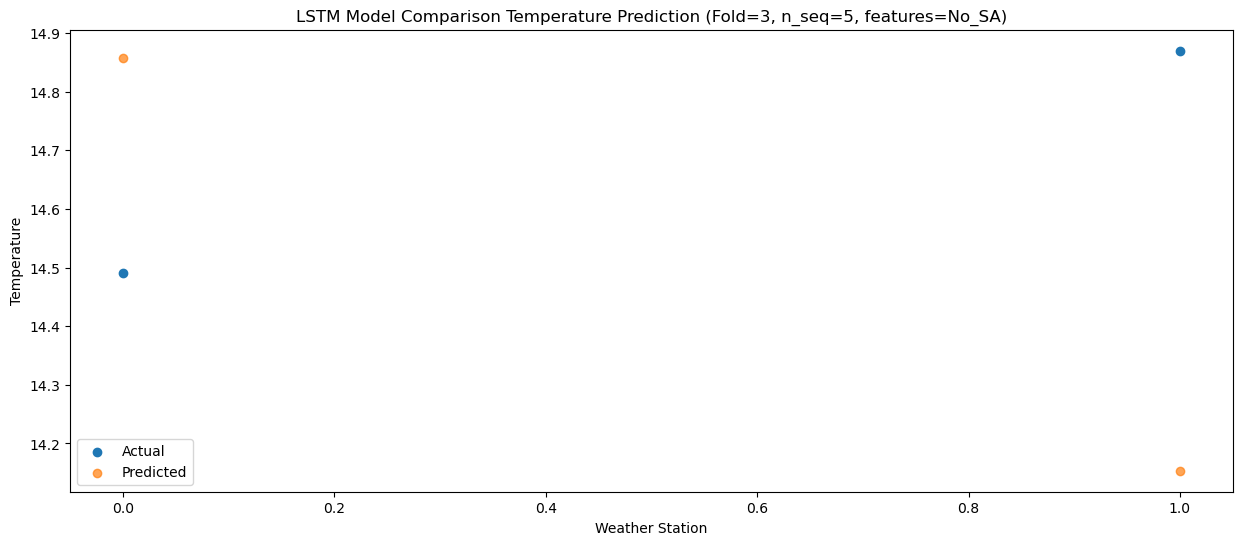

f, t:
[[14.42 14.47]
 [14.47 14.35]
 [14.79 14.15]
 [14.78 13.85]
 [14.49 14.87]]
[[14.73868583 14.00758987]
 [15.05827309 14.33695408]
 [14.83332425 14.12316347]
 [14.50314355 13.7876055 ]
 [14.85814532 14.15338329]]
Year at t+1:
t+1 SKRMSE: 0.397104
t+1 KRMSE: 0.397104
t+1 MAE: 0.390548
t+1 SKMAPE: 0.027028
t+1 R2_SCORE: -251.307031
t+1 KMAPE: 0.027028
t+1 PEARSON: 1.000000
Year at t+2:
t+2 SKRMSE: 0.416074
t+2 KRMSE: 0.416074
t+2 MAE: 0.300660
t+2 SKMAPE: 0.020782
t+2 R2_SCORE: -47.088253
t+2 KMAPE: 0.020782
t+2 PEARSON: 1.000000
Year at t+3:
t+3 SKRMSE: 0.036036
t+3 KRMSE: 0.036036
t+3 MAE: 0.035080
t+3 SKMAPE: 0.002413
t+3 R2_SCORE: 0.987318
t+3 KMAPE: 0.002413
t+3 PEARSON: 1.000000
Year at t+4:
t+4 SKRMSE: 0.200677
t+4 KRMSE: 0.200677
t+4 MAE: 0.169625
t+4 SKMAPE: 0.011618
t+4 R2_SCORE: 0.813753
t+4 KMAPE: 0.011618
t+4 PEARSON: 1.000000
Year at t+5:
t+5 SKRMSE: 0.569680
t+5 KRMSE: 0.569680
t+5 MAE: 0.542381
t+5 SKMAPE: 0.036799
t+5 R2_SCORE: -7.989896
t+5 KMAPE: 0.036799
t+5 PEAR

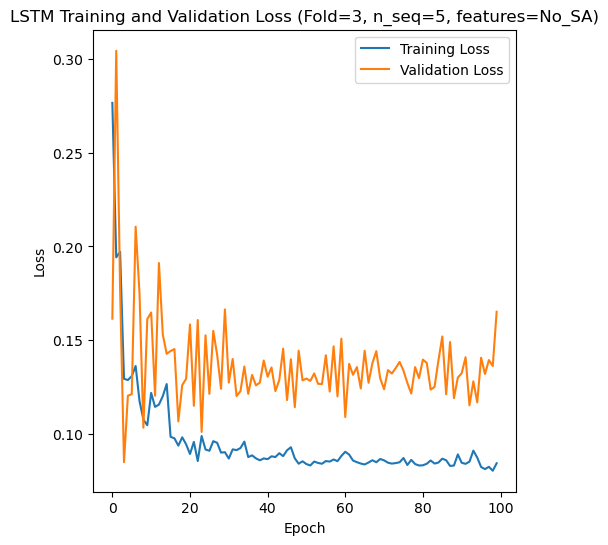

[[21.14 18.96 18.26 17.93 17.59 18.09 18.   18.94 19.77 18.17 18.51 17.84
  17.96 19.05 19.41 17.5  17.5  18.37 18.89 19.09 18.25 18.12 18.64 18.22
  18.72 19.65 20.58]
 [12.93 12.18 11.5  12.1  11.94 11.27 11.81 12.49 12.65 12.57 10.89 11.63
  12.44 12.56 14.1  11.08 10.78 12.73 13.75 13.68 12.38 11.68 12.24 12.56
  11.69 13.17 14.51]]
Epoch 1/100
19/19 [==============================] - 5s 67ms/step - loss: 0.2665 - accuracy: 0.2105 - mae: 0.2393 - rmse: 0.2665 - mape: 39.3095 - pearson: 0.3830 - val_loss: 0.1385 - val_accuracy: 1.0000 - val_mae: 0.1096 - val_rmse: 0.1385 - val_mape: 23.3793 - val_pearson: 0.7651
Epoch 2/100
19/19 [==============================] - 0s 8ms/step - loss: 0.1676 - accuracy: 0.2105 - mae: 0.1410 - rmse: 0.1676 - mape: 22.7613 - pearson: 0.3038 - val_loss: 0.1585 - val_accuracy: 1.0000 - val_mae: 0.1205 - val_rmse: 0.1585 - val_mape: 24.5740 - val_pearson: 0.3027
Epoch 3/100
19/19 [==============================] - 0s 8ms/step - loss: 0.1511 - accuracy: 0.

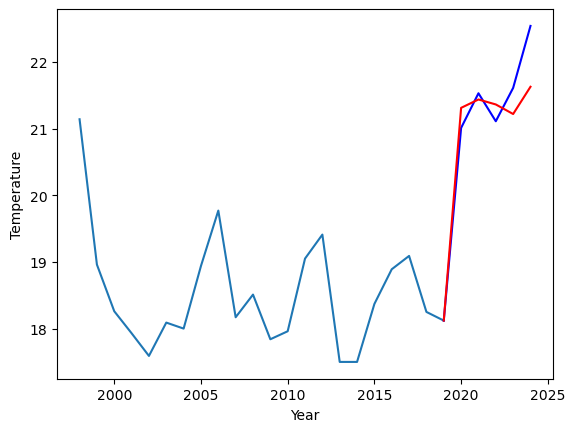

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
12.23		12.90		0.67
12.79		13.25		0.46
13.11		13.28		0.17
12.24		12.87		0.63
13.72		13.37		-0.35


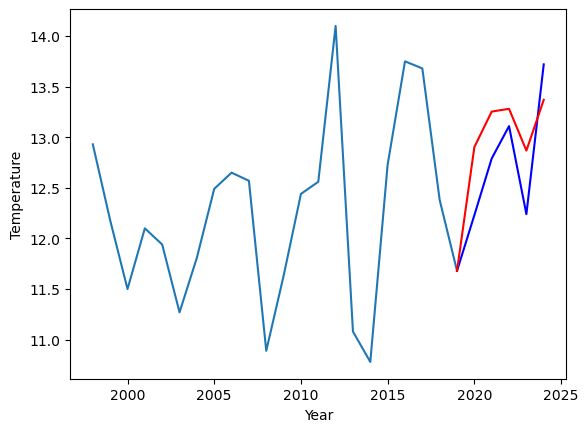

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   21.01  21.311049
1                1   12.23  12.902776


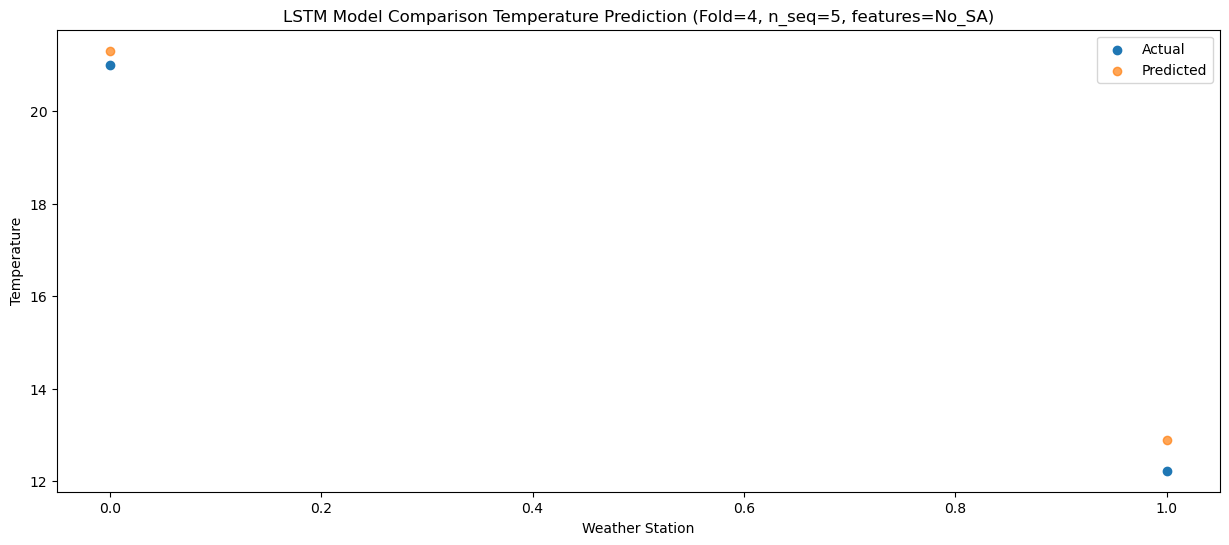

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   21.53  21.436597
1                1   12.79  13.253545


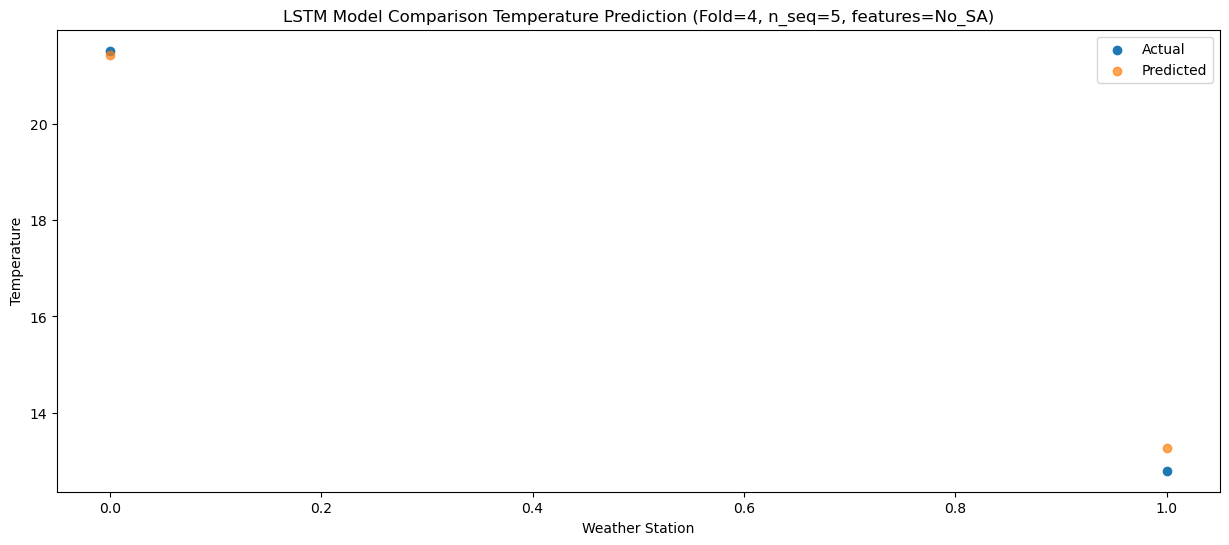

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   21.11  21.361985
1                1   13.11  13.280912


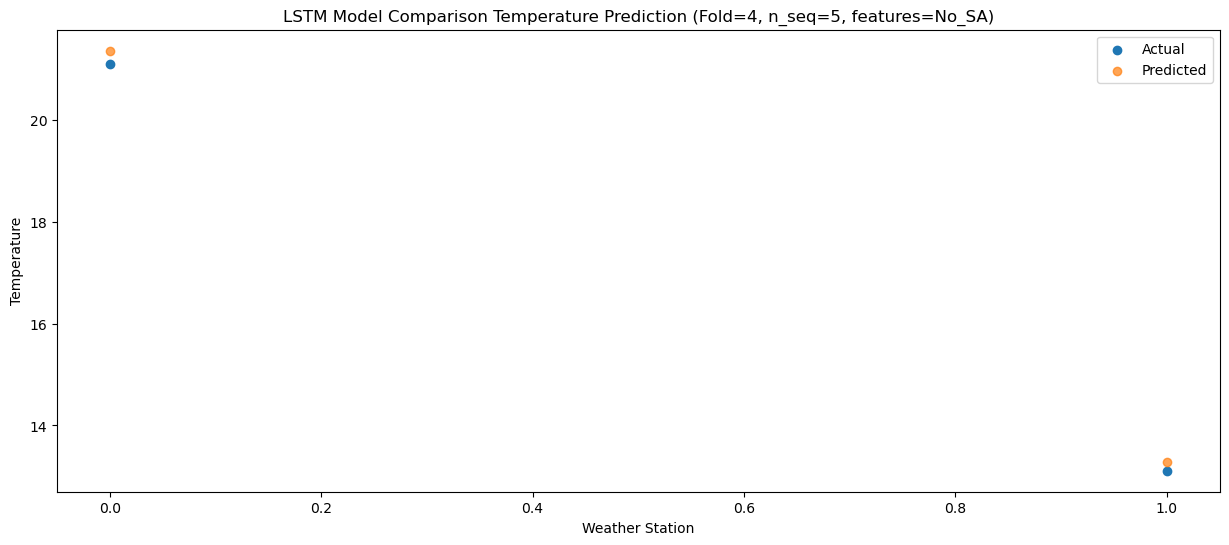

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   21.61  21.218577
1                1   12.24  12.868314


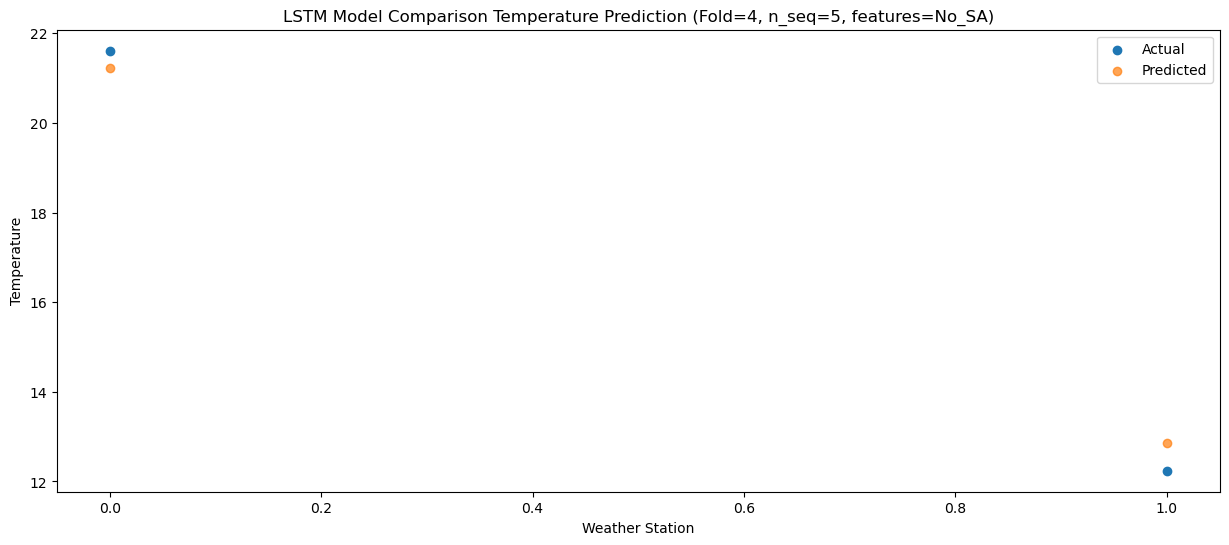

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   22.54  21.627361
1                1   13.72  13.369282


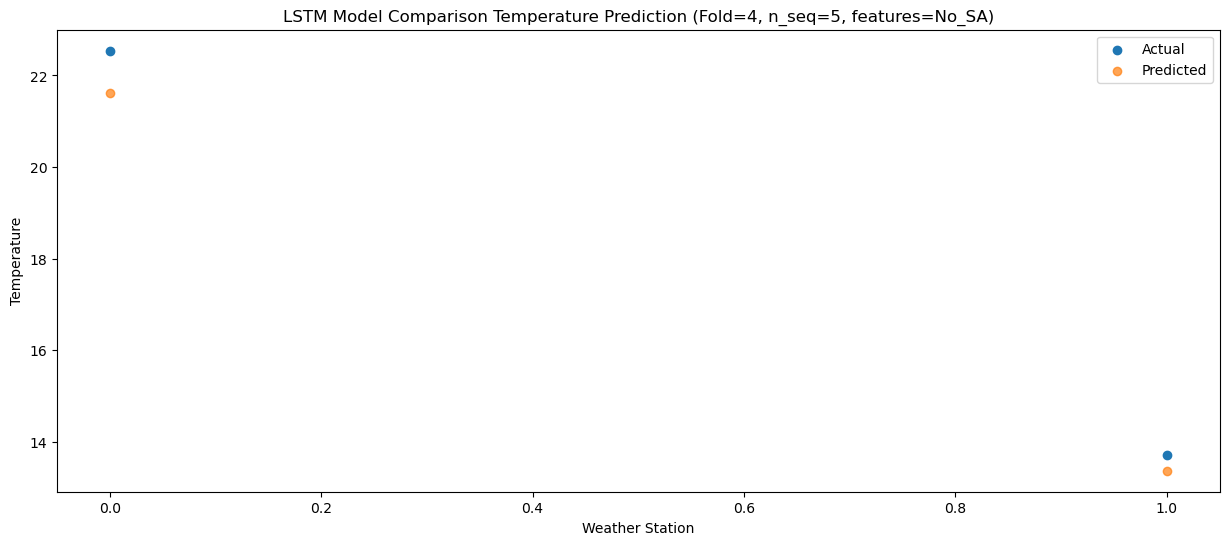

f, t:
[[21.01 12.23]
 [21.53 12.79]
 [21.11 13.11]
 [21.61 12.24]
 [22.54 13.72]]
[[21.31104855 12.90277588]
 [21.43659723 13.2535454 ]
 [21.36198454 13.28091173]
 [21.21857737 12.86831372]
 [21.6273606  13.36928211]]
Year at t+1:
t+1 SKRMSE: 0.521180
t+1 KRMSE: 0.521180
t+1 MAE: 0.486912
t+1 SKMAPE: 0.034670
t+1 R2_SCORE: 0.985906
t+1 KMAPE: 0.034670
t+1 PEARSON: 1.000000
Year at t+2:
t+2 SKRMSE: 0.334364
t+2 KRMSE: 0.334364
t+2 MAE: 0.278474
t+2 SKMAPE: 0.020291
t+2 R2_SCORE: 0.994146
t+2 KMAPE: 0.020291
t+2 PEARSON: 1.000000
Year at t+3:
t+3 SKRMSE: 0.215299
t+3 KRMSE: 0.215299
t+3 MAE: 0.211448
t+3 SKMAPE: 0.012487
t+3 R2_SCORE: 0.997103
t+3 KMAPE: 0.012487
t+3 PEARSON: 1.000000
Year at t+4:
t+4 SKRMSE: 0.523445
t+4 KRMSE: 0.523445
t+4 MAE: 0.509868
t+4 SKMAPE: 0.034723
t+4 R2_SCORE: 0.987517
t+4 KMAPE: 0.034723
t+4 PEARSON: 1.000000
Year at t+5:
t+5 SKRMSE: 0.691344
t+5 KRMSE: 0.691344
t+5 MAE: 0.631679
t+5 SKMAPE: 0.033026
t+5 R2_SCORE: 0.975424
t+5 KMAPE: 0.033026
t+5 PEARSON: 1

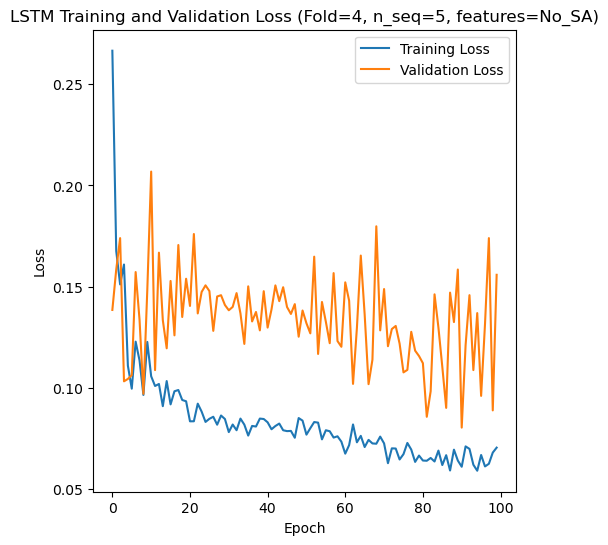

[[0.6173765330754969], [0.7542380479922997], [0.48045011346445754], [0.37334025506460644], [0.48615497241787736]]
[[array(0.61737653)], [array(0.75423805)], [array(0.48045011)], [array(0.37334026)], [array(0.48615497)]]
[[0.4866881404221065], [0.5970984956026083], [0.3727974621653557], [0.28765887458622463], [0.42367625045031315]]
[[0.027297631384201448], [0.030593441540814403], [0.02392391274995521], [0.019728221463336627], [0.027039180836517508]]
[[0.9220108053110452], [-0.4301103941818498], [0.9245995938067924], [-0.6165214563428445], [0.9878237533978892]]
[[array(0.02729763)], [array(0.03059344)], [array(0.02392391)], [array(0.01972822)], [array(0.02703918)]]
[[array(0.93050828)], [array(0.12800291)], [array(0.92540452)], [array(0.21187288)], [array(0.99145731)]]
[[[20.66489050924778, 21.342749279141426, 21.457814227938652, 20.785421501994133, 21.549303185343742], [16.39936891913414, 17.034788049459458, 17.12411482602358, 16.464304104149342, 17.203488662540913]], [[19.2154270792007

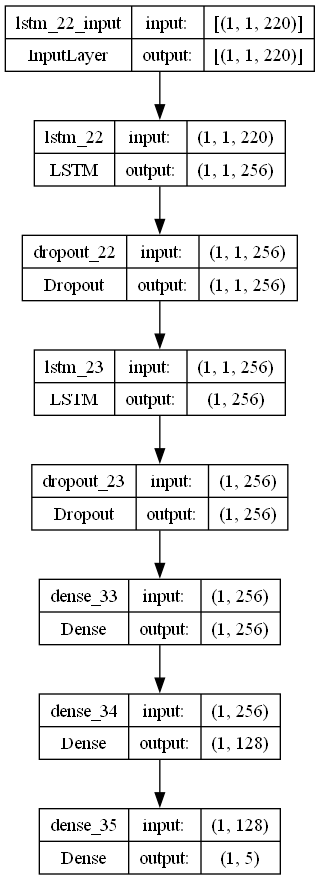

In [32]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.utils import plot_model

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def kmape (y_true, y_pred):
    return K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def kpearson (y_true, y_pred):
    mean_true = K.mean(y_true)
    mean_pred = K.mean(y_pred)
    return (K.square(K.mean((y_true - mean_true)*(y_pred - mean_pred))))/(K.mean(K.square(y_true - mean_true))*K.mean(K.square(y_pred - mean_pred)))

# fit the best LSTM model using parameters found by Optuna
def create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch):
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters from the best model
    lr = 0.003047148059884415
    optimizer = Adam(learning_rate = lr)
    activation_function = 'relu'
    lstm_units = 256
    dropout_rate = 0.26876821543893603

    # design network
    model = Sequential()
    #model.add(Conv1D(filters=filters, kernel_size=1, activation='relu', input_shape=(X.shape[1], X.shape[2]))) # CNN-LSTM only
    model.add(LSTM(lstm_units, return_sequences=True, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer, metrics=['accuracy', 'mae', rmse, mape, pearson])
        
    return model

# make one forecast with an LSTM,
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def forecast_lstm(model, X, n_seq, n_test):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, X.shape[1])
    # make forecast
    forecast = model.predict(X)
    # convert to array
    return forecast
     
# evaluate the persistence model
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def make_forecasts(model, X_test, y_test, n_lag, n_seq, n_test):
    forecasts = list()
    for i in range(len(X_test)):
        X, y = X_test[i, :], y_test[i, :]
        # make forecast
        forecast = forecast_lstm(model, X, n_seq, n_test)
        # store the forecast
        forecasts.append(forecast)
    return forecasts
     
# Invert differenced forecast
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_difference(last_ob, forecast):
    # Invert the first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # Propagate the difference forecast using the inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted
     
# Inverse data transform on forecasts
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_transform(series, forecasts, scaler, n_test, n_seq):
    inverted = list()
    for i in range(len(forecasts)):
        # create an array from the forecast
        forecast = forecasts[i]
        forecast = forecast.reshape(1, n_seq)
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted
     
# Evaluate the RMSE for each forecast time step
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def evaluate_forecasts(actual, forecasts, n_lag, n_seq):

    t = np.array(actual).transpose()
    f = np.array(forecasts).transpose()

    print("f, t:")
    print(t)
    print(f)
    rmse_list = []
    mae_list = []
    skmape_list = []
    mape_list = []
    r2_list = []
    pearson_list = []

    for i in range(n_seq):
        act = [row for row in t[i]]
        predicted = [forecast for forecast in f[i]]
        rmse1 = sqrt(mean_squared_error(act, predicted))
        rmse2 = np.array(rmse(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        mae = mean_absolute_error(act, predicted)
        mse = mean_squared_error(act, predicted)
        skmape = mean_absolute_percentage_error(act, predicted)
        kmape1 = np.array(kmape(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        kpearson1 = np.array(kpearson(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        r2 = r2_score(act, predicted) 
        print("Year at t+"+str(i+1)+":")
        print('t+%d SKRMSE: %f' % ((i+1), rmse1))
        print('t+%d KRMSE: %f' % ((i+1), rmse2))        
        print('t+%d MAE: %f' % ((i+1), mae))
        print('t+%d SKMAPE: %f' % ((i+1), skmape))
        print('t+%d R2_SCORE: %f' % ((i+1), r2))
        print('t+%d KMAPE: %f' % ((i+1), kmape1))
        print('t+%d PEARSON: %f' % ((i+1), kpearson1))

    y_true = tf.convert_to_tensor(np.array(actual).flatten())
    y_pred = tf.convert_to_tensor(np.array(forecasts).flatten())

    rmse1 = sqrt(mean_squared_error(np.array(y_true), np.array(y_pred)))
    rmse2 = np.array(rmse(y_true, y_pred))
    mae = mean_absolute_error(np.array(y_true), np.array(y_pred))
    mse = mean_squared_error(np.array(y_true), np.array(y_pred))
    skmape = mean_absolute_percentage_error(np.array(y_true), np.array(y_pred))
    kmape1 = np.array(kmape(y_true, y_pred))
    kpearson1 = np.array(kpearson(y_true, y_pred))
    r2 = r2_score(np.array(y_true), np.array(y_pred)) 
    rmse1_list.append(rmse1)
    rmse2_list.append(rmse2)
    mae_list.append(mae)
    skmape_list.append(skmape)
    pearson_list.append(kpearson1)
    mape_list.append(kmape1)
    r2_list.append(r2)
    print("Metrics for this Fold:")
    print('SKRMSE: %f' % (rmse1))
    print('KRMSE: %f' % (rmse2))        
    print('MAE: %f' % (mae))
    print('SKMAPE: %f' % (skmape))
    print('R2_SCORE: %f' % (r2))
    print('KMAPE: %f' % (kmape1))
    print('PEARSON: %f' % (kpearson1))

    return rmse1_list, rmse2_list, mae_list, skmape_list, r2_list, mape_list, pearson_list
     
# Plot the forecasts in the context of the original dataset
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def plot_forecasts(series, forecasts, actual, n_test, n_seq, n_lag):
    # Plot the actual data in blue
    plt.plot(series[:n_lag+2].index, series[:n_lag+2].values)
    off_s = n_lag + 1
    off_e = off_s + len(actual) + 1
    xaxis = [1998+x for x in range(off_s, off_e)]
    yaxis = [series.values[off_s]] + actual
    plt.plot(xaxis, yaxis, color='blue')
    # Plot the forecasts in red
    off_s = n_lag + 1
    off_e = off_s + len(forecasts) + 1
    xaxis = [1998+x for x in range(off_s, off_e)]
    yaxis = [series.values[off_s]] + forecasts
    plt.plot(xaxis, yaxis, color='red')
    plt.xlabel("Year")
    plt.ylabel("Temperature")
    # show the plot
    plt.show()

n_batch = 1
n_test = 2
nb_epoch = 100
    
rmse1_avg_list = []
rmse2_avg_list = []
mae_avg_list = []
skmape_avg_list = []
r2_score_avg_list = []
mape_avg_list = []
pearson_avg_list = []
forecast_results = []
actual_results = []
    
for i in range(5):
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X = train1[:, 0:-n_seq]
    y = train1[:, -n_seq:]
    X_test = test1[:, 0:-n_seq]
    y_test = test1[:, -n_seq:]
    X_val = validation1[:, 0:-n_seq]
    y_val = validation1[:, -n_seq:]
    
    dataset_df = pd.DataFrame(val_y[i])
    dataset_df = dataset_df.iloc[0:2, :]
    dataset = dataset_df.values

    print(dataset)

    series = pd.Series(dataset[:, 0]) # Using first column (temperatures)

    X = X.reshape(X.shape[0], 1, X.shape[1])
    X1 = X_test
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch)
    history = best_model.fit(X, y, epochs=100, batch_size=n_batch, validation_data=(X_val, y_val))

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

    # make forecasts
    forecasts = make_forecasts(best_model, X_test, y_test, n_lag, n_seq, n_test)
    
    # inverse transform forecasts and test
    forecasts = inverse_transform(series, forecasts, scaler[i], n_test, n_seq)
    actual = [row[-n_seq:] for row in test1]
    actual = inverse_transform(series, actual, scaler[i], n_test, n_seq)

    # Print out plots of actual and predicted values for weather stations
    ws = [1,2]
    print(ws)
    a = []
    f = []
    for q in range(len(actual)):
        x = actual[q]
        a.append(x[0])
    for q in range(len(forecasts)):
        x = forecasts[q]
        f.append(x[0])
    print(a)
    print(f)
    # Create a DataFrame for plotting
    results_df = pd.DataFrame({
        'ws': ws,
        'Actual': a,
        'Predicted': f
    })

    print(results_df)
    
    print("Actual and Forecasts:")
    print(actual)
    print(forecasts)
    
    for j in range(2):
        print("Weather Station "+str(j+1)+":")
        print("Actual Temp\tPredicted Temp\tDifference")
        print("-----------\t--------------\t----------")
        for k in range(n_seq):
            diff = forecasts[j][k] - actual[j][k]
            print(f"{actual[j][k]:.2f}\t\t{forecasts[j][k]:.2f}\t\t{diff:.2f}")

        # plot forecasts
        dataset_df = pd.DataFrame(val_y[i])
        dataset_df = dataset_df.iloc[0:2, :]
        dataset_df = dataset_df.transpose()
        dataset = dataset_df.values

        series_ws = pd.Series(dataset[:, j]) # Using first column (temperatures)
        forecasts_ws = forecasts[j]
        actual_ws = actual[j]

        # Set index starting from 1998
        series_ws.index = range(1998, 1998 + len(series_ws))        
        
        plot_forecasts(series_ws, forecasts_ws, actual_ws, n_test, n_seq, n_lag)

    for k in range(n_seq):
        print("Predictions for (t+"+str(k)+"):")
        # Print out plots of actual and predicted values for each weather station
        results = []

        # Create a DataFrame for plotting
        for j in range(2):
            results.append([j, actual[j][k], forecasts[j][k]])
               
        results_df = pd.DataFrame(results)
        results_df.columns = ['Weather_Station', 'Actual', 'Predicted']

        print(results_df)

        # Plotting the results
        plt.figure(figsize=(15, 6))
        plt.scatter(results_df['Weather_Station'], results_df['Actual'], label='Actual')
        plt.scatter(results_df['Weather_Station'], results_df['Predicted'], label='Predicted', alpha=0.7)
        title1='LSTM Model Comparison Temperature Prediction (Fold='+str(i)+', n_seq='+str(n_seq)+', features=No_SA)'
        plt.title(title1)
        plt.xlabel('Weather Station')
        plt.ylabel('Temperature')
        plt.legend()
        plt.show()
    
    rmse1_list = [] # list stores sklearn's root mean squared errors for each future time prediction
    rmse2_list = [] # list stores root mean squared errors for each future time prediction
    mae_list = [] # list stores mean absolute errors for each future time prediction
    skmape_list = [] # list stores sklearn's mean squared percentage errors for each future time prediction
    r2_list = [] # list stores sklearn's r2 pearson values for each future time prediction
    mape_list = [] # list stores mean squared percentage errors for each future time prediction
    pearson_list = [] # list stores r2 pearson values for each future time prediction

    # evaluate forecasts
    rmse1_list, rmse2_list, mae_list, skmape_list, r2_list, mape_list, pearson_list = evaluate_forecasts(actual, forecasts, n_lag, n_seq)

    rmse1_avg_list.append(rmse1_list)
    rmse2_avg_list.append(rmse2_list)
    mae_avg_list.append(mae_list)
    skmape_avg_list.append(skmape_list)
    r2_score_avg_list.append(r2_list)
    mape_avg_list.append(mape_list)
    pearson_avg_list.append(pearson_list)                        
    forecast_results.append(forecasts)
    actual_results.append(actual)
            
    best_model.summary()

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title2 = 'LSTM Training and Validation Loss (Fold='+str(i)+', n_seq='+str(n_seq)+', features=No_SA)'
    plt.title(title2)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

print(rmse1_avg_list)
print(rmse2_avg_list)
print(mae_avg_list)
print(skmape_avg_list)
print(r2_score_avg_list)
print(mape_avg_list)
print(pearson_avg_list)
print(forecast_results)
print(actual_results)
print("Accuracy Results:")
print("RMSE for each fold:")
print(rmse1_avg_list)
print("Average SKRMSE:"+str(np.mean(rmse1_avg_list)))
print("Average KRMSE:"+str(np.mean(rmse2_avg_list)))
print("Average MAE:"+str(np.mean(mae_avg_list)))
print("Average SKMAPE:"+str(np.mean(skmape_avg_list)))
print("Average MAPE:"+str(np.mean(mape_avg_list)))
print("Average PEARSON:"+str(np.mean(pearson_avg_list)))
print("Average R2 Score:"+str(np.mean(r2_score_avg_list)))

# Plot model architecture
filename = "lstm_model_optimized_CV_S5_No_SA.png"
plot_model(best_model, to_file=filename, show_shapes=True, show_layer_names=True)

In [29]:
y_true = tf.convert_to_tensor(np.array(actual).flatten())
y_pred = tf.convert_to_tensor(np.array(forecasts).flatten())
mean_true = K.mean(y_true)
print(mean_true)
print((K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred)))))

tf.Tensor(17.189, shape=(), dtype=float64)
tf.Tensor(0.9922954880291276, shape=(), dtype=float64)


In [28]:
print(np.array(actual).flatten())
print(np.array(forecasts).flatten())

[21.01 21.53 21.11 21.61 22.54 12.23 12.79 13.11 12.24 13.72]
[21.17811817 21.91794503 22.16079082 21.5264342  22.24187835 12.87163067
 13.84647894 14.26000592 13.47100547 14.31717661]


In [7]:
print(r2_score_avg_list[1])

[0.8597846123766837, 0.9930535918085576, 0.955085060779647, 0.9950733322746518, 0.9290472291473355]


In [8]:
print(r2_score_avg_list[2])

[0.8597846123766837, 0.9930535918085576, 0.955085060779647, 0.9950733322746518, 0.9290472291473355]


In [9]:
print(r2_score_avg_list[3])

[0.8597846123766837, 0.9930535918085576, 0.955085060779647, 0.9950733322746518, 0.9290472291473355]


In [10]:
print(r2_score_avg_list[4])

[0.8597846123766837, 0.9930535918085576, 0.955085060779647, 0.9950733322746518, 0.9290472291473355]


In [12]:
print(np.mean(r2_score_avg_list[0]))

0.9464087652773753


In [16]:
print(len(r2_score_avg_list))

25


In [38]:
y_true = np.array([23.32, 3])
y_pred = np.array([22.7, 3.1])
print(np.array(100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)))

2.9959977129788484
